# Notebook for visualization, 1x4 2D plots for main simulations 

In [2]:
import h5py
import numpy as np
import matplotlib
import yt 
import cmasher as cmr 
from mpl_toolkits.axes_grid1 import AxesGrid

matplotlib.rcParams['mathtext.default']='regular'
matplotlib.rcParams['xtick.direction']='in'

matplotlib.rcParams['ytick.direction']='in'
matplotlib.rcParams['xtick.top']=True
matplotlib.rcParams['ytick.right']=True
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
#import pyatomdb as padb 
from scipy import interpolate 
from scipy.integrate import solve_ivp, odeint, trapz, quad
from scipy.optimize import newton, brentq


from matplotlib import rc
from matplotlib.ticker import ScalarFormatter, AutoMinorLocator, LogLocator

#matplotlib.font_manager._rebuild()

rc('font', family='serif')
rc('text', usetex=True)
params =   {'font.size' : 12,
                'text.usetex' : True,
                'xtick.major.size': 6,
                'ytick.major.size': 6,
                'xtick.minor.size': 3,
                'ytick.minor.size': 3,
                }
plt.rcParams.update(params)

mu   = 0.6
g    = 5/3
mp   = 1.672622e-24
kb   = 1.380658e-16
pc   = 3.08567758e18       # [cm]      pc 
kpc  = 3.08567758e21       # [cm]      kiloparsec
Msun = 1.98855e33          # [g]       solar mass
yr   = 3.15569e7           # [s]       year
kyr  = yr * 1e3

### Load MLI_a,b,c 
### This will kill computer memory, but we just need it for basic 2D plots. 
### Do not run unless you explicitly need all three 512^3 plots.

In [2]:
# Dimensions of plot, length of x and z simulations domain in kpc (y=0 slice)
# Construction of 3D grid too. 
xlen = 6.0
ylen = 6.0 
zlen = 6.0

x_cen = xlen / 2.0 * kpc 
y_cen = ylen / 2.0 * kpc 
z_cen = zlen / 2.0 * kpc 

nx = 512
ny = 512
nz = 512

x = np.linspace(0,xlen,nx) * kpc
y = np.linspace(0,ylen,ny) * kpc
z = np.linspace(0,zlen,nz) * kpc

# Generate the grid and then the shifted positions 
xm, ym, zm = np.meshgrid(x,y,z,indexing='ij')
xS, yS, zS = xm - x_cen, ym - y_cen, zm - z_cen

# Generate spherical coordinates on cartesian grid 
r_sph     = np.sqrt(xS**2 + yS**2 + zS**2 )
theta_sph = np.arctan2(np.sqrt(xS**2 + yS**2), zS)
phi_sph   = np.arctan2(yS, xS) 

number = 0
# Load in all of the data... this will kill the computer memory. 

datapath_a = '/Users/dustin/Desktop/cholla_simulations/2023/mass-loading/spherical_data/2022_512cubed_sims/'
datapath_b = datapath_a
datapath_c = datapath_a

# number of the h5 file
h5n_a = 80
h5n_b = 80
h5n_c = 80

for i in np.arange(0,number+1,1):
    # DATA [A] 
    DE = 1 
    SCALAR = 1
    f_a = h5py.File(datapath_c+'mli_a_'+str(h5n_a)+'.h5', 'r')
    head_a = f_a.attrs
    nx = head_a['dims'][0]
    ny = head_a['dims'][1]
    nz = head_a['dims'][2]
    gamma = head_a['gamma'][0]
    dunit = head_a['density_unit']
    vunit = head_a['velocity_unit']
    punit = head_a['energy_unit']
    d_a  = np.array(f_a['density'])      # mass density
    mx_a = np.array(f_a['momentum_x'])   # x-momentum
    my_a = np.array(f_a['momentum_y'])   # y-momentum
    mz_a = np.array(f_a['momentum_z'])   # z-momentum
    E_a  = np.array(f_a['Energy'])       # total energy density
    vx_a = mx_a/d_a
    vy_a = my_a/d_a
    vz_a = mz_a/d_a
    if DE:
        e_a  = np.array(f_a['GasEnergy'])
        p_a  = e_a*(gamma-1.0)
        ge_a = e_a/d_a
    else:
        p_a  = (E_a - 0.5*d_a*(vx_a*vx_a + vy_a*vy_a + vz_a*vz_a)) * (gamma - 1.0)
        ge_a  = p_a/d_a/(gamma - 1.0)
    if SCALAR:
        s_a  = np.array(f_a['scalar0'])/d_a 
        
     # CGS units here    
    n_a     = d_a*dunit / (0.6 * mp)
    rho_a   = n_a * 0.6 * mp
    vx_a    = vx_a*vunit
    vy_a    = vy_a*vunit
    vz_a    = vz_a*vunit
    vmag_a  = np.sqrt(vx_a**2 + vy_a**2 + vz_a**2)
    p_a     = p_a*punit
    T_a     = p_a / (n_a*kb)
    cs_a = np.sqrt(gamma*(p_a)/(n_a*0.6*mp))
    M_a = vmag_a / cs_a 
    
    # DATA[B]
    f_b = h5py.File(datapath_b+'mli_b_'+str(h5n_b)+'.h5', 'r')
    head_b = f_b.attrs
    nx = head_b['dims'][0]
    ny = head_b['dims'][1]
    nz = head_b['dims'][2]
    gamma = head_b['gamma'][0]
    dunit = head_b['density_unit']
    vunit = head_b['velocity_unit']
    punit = head_b['energy_unit']
    d_b  = np.array(f_b['density'])      # mass density
    mx_b = np.array(f_b['momentum_x'])   # x-momentum
    my_b = np.array(f_b['momentum_y'])   # y-momentum
    mz_b = np.array(f_b['momentum_z'])   # z-momentum
    E_b  = np.array(f_b['Energy'])       # total energy density
    vx_b = mx_b/d_b
    vy_b = my_b/d_b
    vz_b = mz_b/d_b
    if DE:
        e_b  = np.array(f_b['GasEnergy'])
        p_b  = e_b*(gamma-1.0)
        ge_b = e_b/d_b
    else:
        p_b  = (E_b - 0.5*d_b*(vx_b*vx_b + vy_b*vy_b + vz_b*vz_b)) * (gamma - 1.0)
        ge_b  = p_b/d_b/(gamma - 1.0)
    if SCALAR:
        s_b  = np.array(f_b['scalar0'])/d_b
        
     # CGS units here    
    n_b     = d_b*dunit / (0.6 * mp)
    rho_b   = n_b * 0.6 * mp
    vx_b    = vx_b*vunit
    vy_b    = vy_b*vunit
    vz_b    = vz_b*vunit
    vmag_b  = np.sqrt(vx_b**2 + vy_b**2 + vz_b**2)
    p_b     = p_b*punit
    T_b     = p_b / (n_b*kb)
    cs_b = np.sqrt(gamma*(p_b)/(n_b*0.6*mp))
    M_b = vmag_b / cs_b
    
    # DATA [C]
    f_c = h5py.File(datapath_a+'mli_c_'+str(h5n_c)+'.h5', 'r')
    head_c = f_c.attrs
    nx = head_c['dims'][0]
    ny = head_c['dims'][1]
    nz = head_c['dims'][2]
    gamma = head_c['gamma'][0]
    dunit = head_c['density_unit']
    vunit = head_c['velocity_unit']
    punit = head_c['energy_unit']
    d_c  = np.array(f_c['density'])      # mass density
    mx_c = np.array(f_c['momentum_x'])   # x-momentum
    my_c = np.array(f_c['momentum_y'])   # y-momentum
    mz_c = np.array(f_c['momentum_z'])   # z-momentum
    E_c  = np.array(f_c['Energy'])       # total energy density
    vx_c = mx_c/d_c
    vy_c = my_c/d_c
    vz_c = mz_c/d_c
    if DE:
        e_c  = np.array(f_c['GasEnergy'])
        p_c  = e_c*(gamma-1.0)
        ge_c = e_c/d_c
    else:
        p_c  = (E_c - 0.5*d_c*(vx_c*vx_c + vy_c*vy_c + vz_c*vz_c)) * (gamma - 1.0)
        ge_c  = p_c/d_c/(gamma - 1.0)
    if SCALAR:
        s_c  = np.array(f_c['scalar0'])/d_c 
        
     # CGS units here    
    n_c     = d_c*dunit / (0.6 * mp)
    rho_c   = n_c * 0.6 * mp
    vx_c    = vx_c*vunit
    vy_c    = vy_c*vunit
    vz_c    = vz_c*vunit
    vmag_c  = np.sqrt(vx_c**2 + vy_c**2 + vz_c**2)
    p_c     = p_c*punit
    T_c     = p_c / (n_c*kb)
    cs_c = np.sqrt(gamma*(p_c)/(n_c*0.6*mp))
    M_c = vmag_c / cs_c

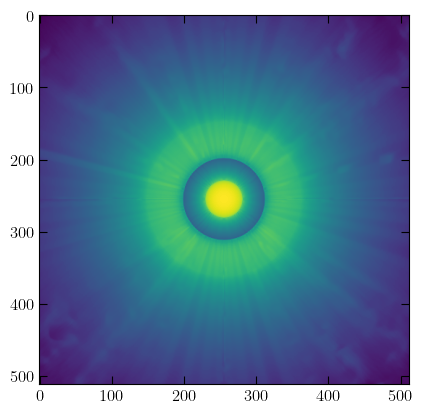

In [3]:
# Now for MLI_b_mudot6 because Todd wants it...
num=4
datapath = '/Users/dustin/Desktop/cholla_simulations/2023/mass-loading/spherical_data/mli_b_mudot6/'
n_d = np.load(datapath+str(num)+'n_a.npy')
M_d = np.load(datapath+str(num)+'M_a.npy')

plt.imshow(np.log10(n_d))

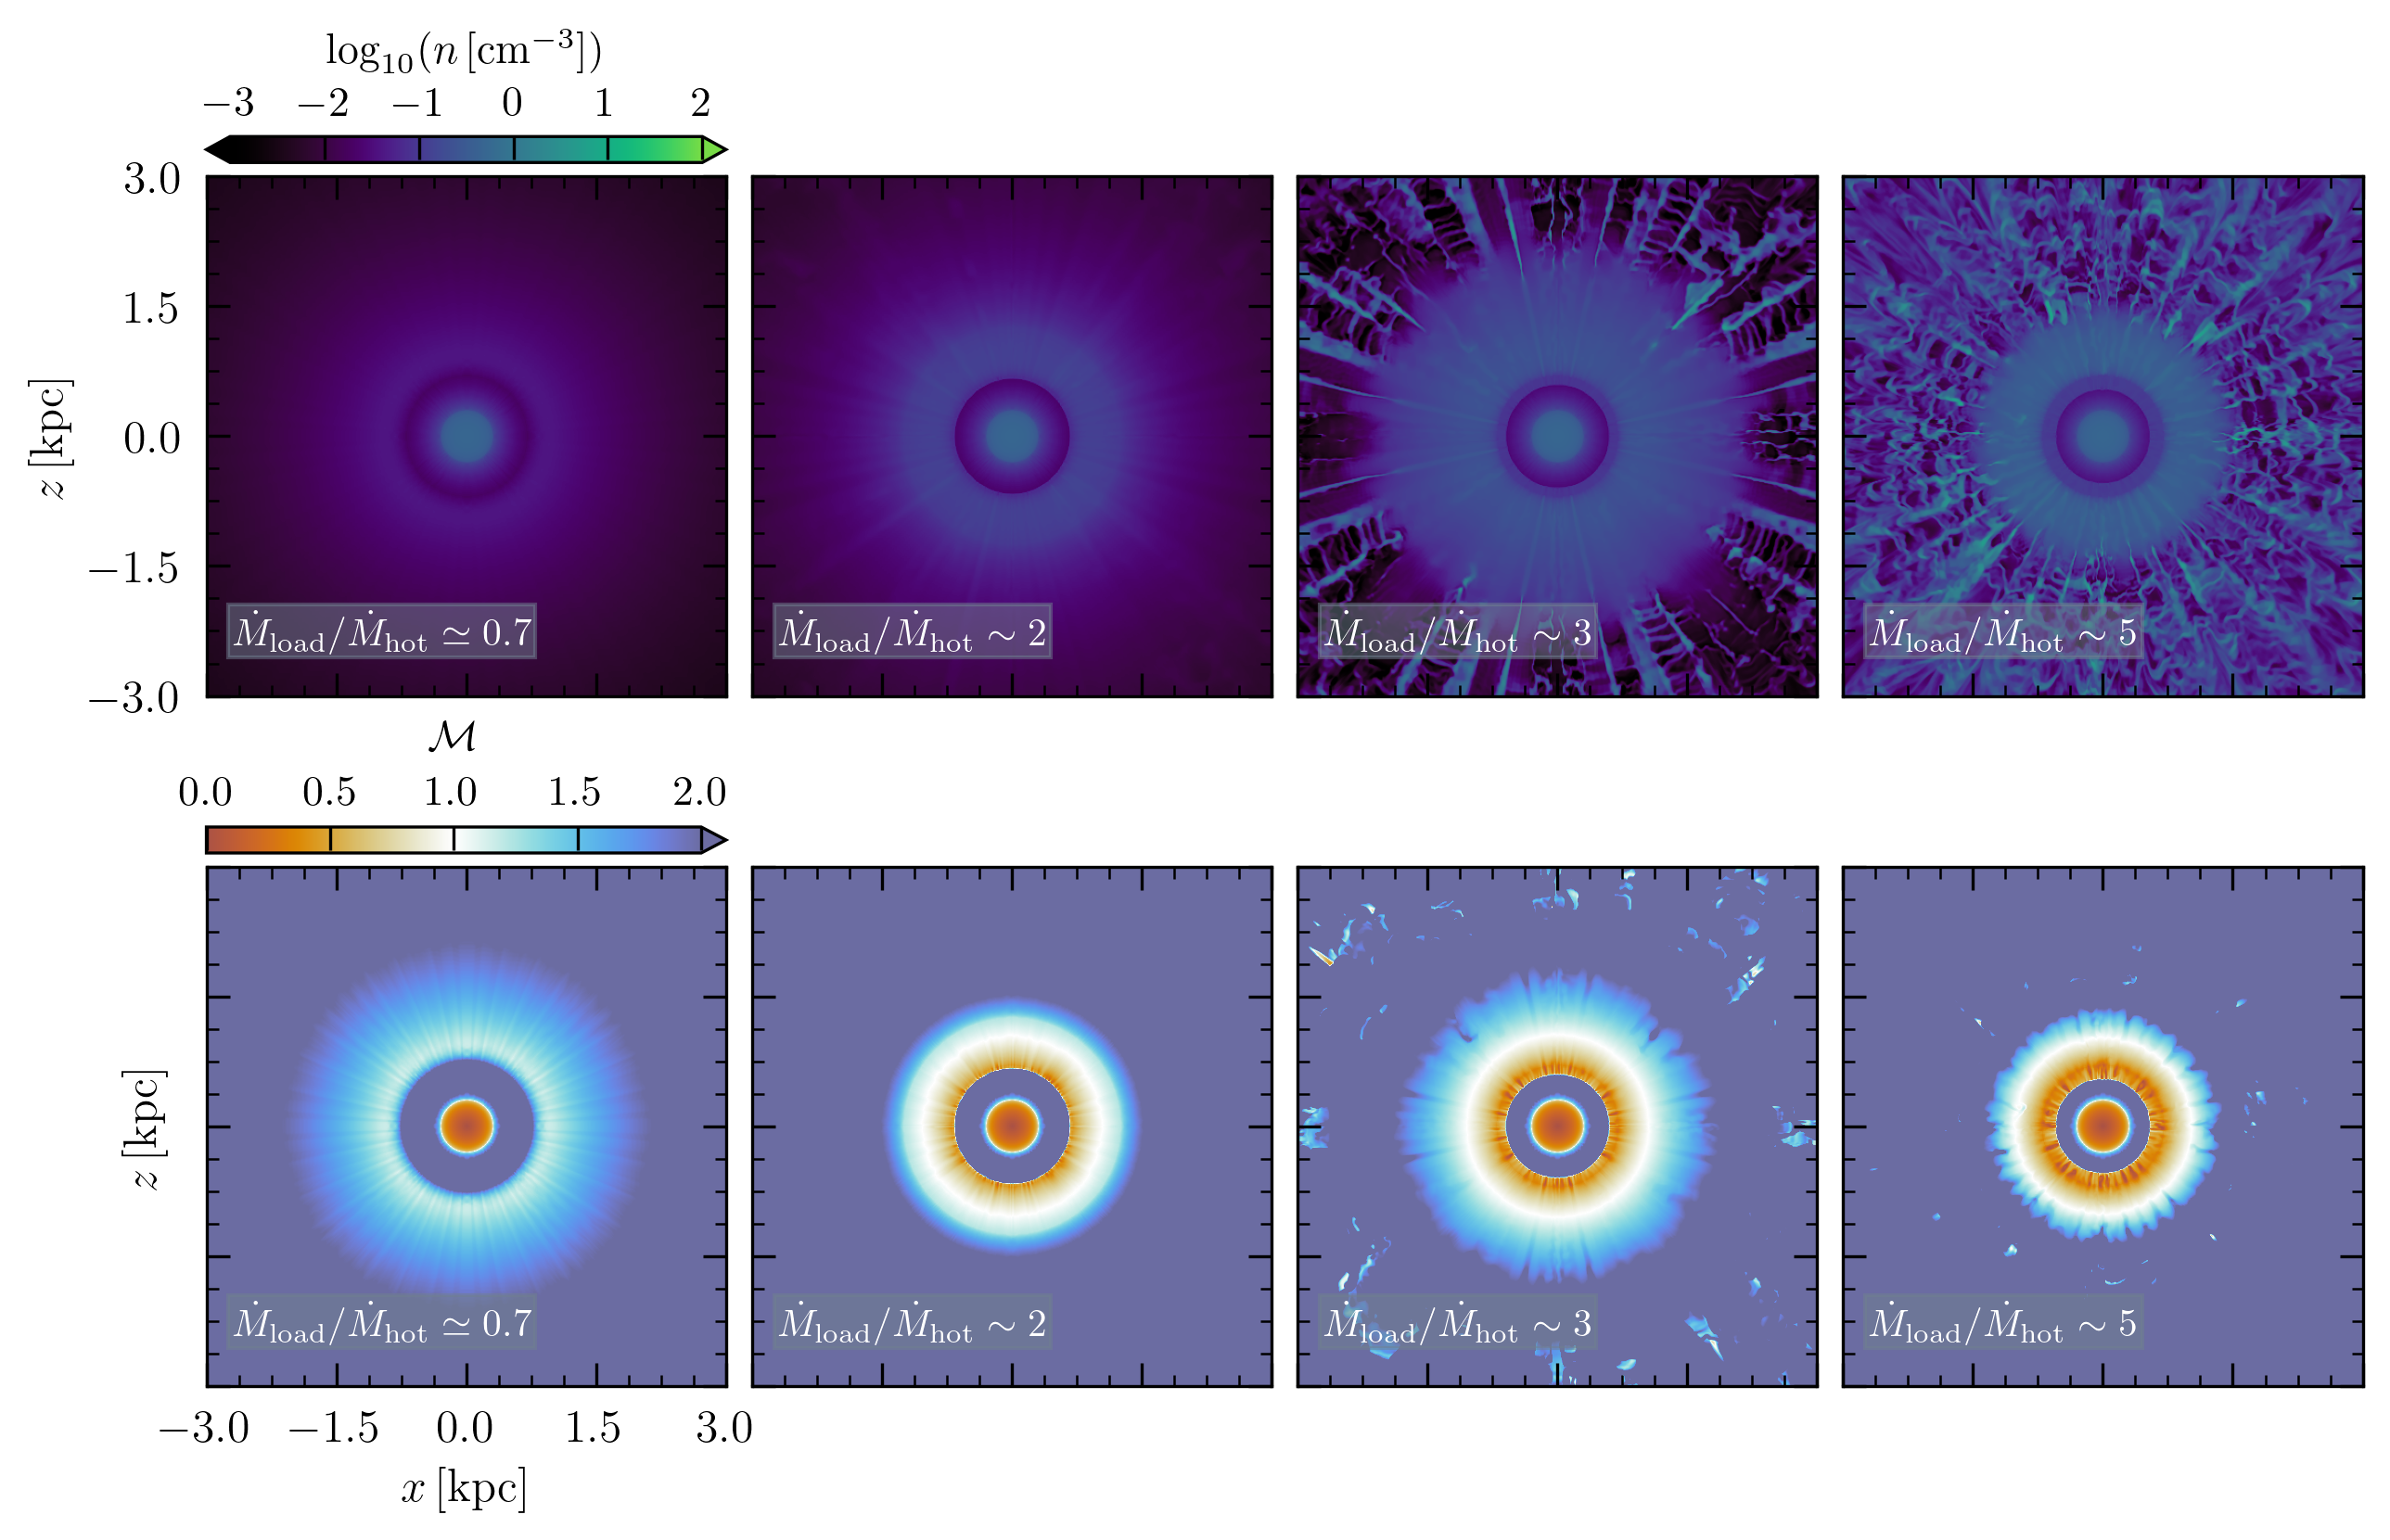

In [7]:
dticks = 1.5       # kpc 
xticks = np.arange((-xlen/2),(xlen/2)+dticks,dticks)
yticks = np.arange((-zlen/2),(zlen/2)+dticks,dticks)
dt = 0.25     # Myr ; 100 kyr 



fig = plt.figure(dpi=300,figsize=(10,8))
ax1 = fig.add_subplot(2,4,1)
plt.setp(ax1.get_yticklabels(), visible=True)
plt.setp(ax1.get_xticklabels(), visible=False)

ax1b = fig.add_subplot(2,4,2, sharey=ax1)
plt.setp(ax1b.get_yticklabels(), visible=False)
plt.setp(ax1b.get_xticklabels(), visible=False)

ax2 = fig.add_subplot(2,4,3, sharey=ax1)
plt.setp(ax2.get_yticklabels(), visible=False)
plt.setp(ax2.get_xticklabels(), visible=False)

ax3 = fig.add_subplot(2,4,4, sharey=ax2)
plt.setp(ax3.get_yticklabels(), visible=False)
plt.setp(ax3.get_xticklabels(), visible=False)

ax5 = fig.add_subplot(2,4,5, sharey=ax2)
plt.setp(ax5.get_yticklabels(), visible=False)
plt.setp(ax5.get_xticklabels(), visible=True)

ax6 = fig.add_subplot(2,4,6, sharey=ax2)
plt.setp(ax6.get_yticklabels(), visible=False)
plt.setp(ax6.get_xticklabels(), visible=False)

ax7 = fig.add_subplot(2,4,7, sharey=ax2)
plt.setp(ax7.get_yticklabels(), visible=False)
plt.setp(ax7.get_xticklabels(), visible=False)

ax8 = fig.add_subplot(2,4,8, sharey=ax2)
plt.setp(ax8.get_yticklabels(), visible=False)
plt.setp(ax8.get_xticklabels(), visible=False)



nlog_min = -3 
nlog_max = 2 
nlog_ticks = [-3,-2,-1,0,1,2]
nlog_ticklabels = ['-3','-2','-1','0','1','2']
nlog_cmap = cmr.lavender 

M_min = 0
M_max = 2 
M_ticks = [0,0.5,1.0,1.5,2.0]
M_ticklabels = ['0.0','0.5','1.0','1.5','2.0']
M_cmap = cmr.prinsenvlag

label1 = '$\dot{M}_\mathrm{load} / \dot{M}_\mathrm{hot} \simeq 0.7$'
label2 = '$\dot{M}_\mathrm{load} / \dot{M}_\mathrm{hot} \sim 2$'
label3 = '$\dot{M}_\mathrm{load} / \dot{M}_\mathrm{hot} \sim 3$'
label4 = '$\dot{M}_\mathrm{load} / \dot{M}_\mathrm{hot} \sim 5$'

divider = make_axes_locatable(ax1)
cax = divider.new_vertical(size='5%', pad=0.05)
fig.add_axes(cax)
#text = ax1.annotate('$128^3\,$cells', xy=(0.05,0.875), color='white',size=10,xycoords=ax1.transAxes, bbox=dict(facecolor='slategray', edgecolor='slategray', alpha=0.5, pad=1.0))
text2 = ax1.annotate(label1, xy=(0.05,0.1), color='white',size=10,xycoords=ax1.transAxes, bbox=dict(facecolor='slategray', edgecolor='slategray', alpha=0.5, pad=1.0))
im = ax1.imshow((np.log10(n_c[:,int(ny/2),:])).T,cmap=nlog_cmap,origin='lower',extent=[-xlen/2,xlen/2,-zlen/2,zlen/2])
cbar=fig.colorbar(im,cax=cax,orientation ='horizontal',ticks=nlog_ticks,extend="both")
cbar.ax.set_xticklabels(nlog_ticklabels,rotation=0,size=11) 
#cbar.ax.get_yaxis().labelpad = 20
cbar.ax.set_title('$\log_{10}(n\,$[cm$^{-3}$])', rotation=0, y=3.0,fontsize=11)
im.set_clim(nlog_min,nlog_max)  
cax.xaxis.set_ticks_position("top")
ax1.set_xticks(xticks)
ax1.set_yticks(yticks)
#ax1.set_xlabel('$x\,$[kpc]')
ax1.set_ylabel('$z\,$[kpc]')
ax1.set_xticks(xticks)
ax1.set_yticks(yticks)
ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(which="minor",axis="both", direction="in", top='on',bottom ='on', left='on',right='on',pad=6)
ax1.tick_params(which="major",axis="both", direction="in", top='on',bottom ='on', left='on',right='on',pad=6)


divider = make_axes_locatable(ax1b)
cax = divider.new_vertical(size='5%', pad=0.05)
fig.add_axes(cax)
cax.axis('off')
#text = ax2.annotate('$256^3\,$cells', xy=(0.05,0.875), color='white',size=10,xycoords=ax2.transAxes, bbox=dict(facecolor='slategray', edgecolor='slategray', alpha=0.5, pad=1.0))
text2 = ax1b.annotate(label2, xy=(0.05,0.1), color='white',size=10,xycoords=ax1b.transAxes, bbox=dict(facecolor='slategray', edgecolor='slategray', alpha=0.5, pad=1.0))
im = ax1b.imshow((np.log10(n_d[:,:])).T,cmap=nlog_cmap,origin='lower',extent=[-xlen/2,xlen/2,-zlen/2,zlen/2])
cbar.ax.set_title('', rotation=0, y=3.0,fontsize=11)
im.set_clim(nlog_min,nlog_max)  
cax.xaxis.set_ticks_position("top")
ax1b.set_xticks(xticks)
ax1b.set_yticks(yticks)
ax1b.xaxis.set_minor_locator(AutoMinorLocator())
ax1b.yaxis.set_minor_locator(AutoMinorLocator())
ax1b.tick_params(which="minor",axis="both", direction="in", top='on',bottom ='on', left='on',right='on',pad=6)
ax1b.tick_params(which="major",axis="both", direction="in", top='on',bottom ='on', left='on',right='on',pad=6)



divider = make_axes_locatable(ax2)
cax = divider.new_vertical(size='5%', pad=0.05)
fig.add_axes(cax)
cax.axis('off')
#text = ax2.annotate('$256^3\,$cells', xy=(0.05,0.875), color='white',size=10,xycoords=ax2.transAxes, bbox=dict(facecolor='slategray', edgecolor='slategray', alpha=0.5, pad=1.0))
text2 = ax2.annotate(label3, xy=(0.05,0.1), color='white',size=10,xycoords=ax2.transAxes, bbox=dict(facecolor='slategray', edgecolor='slategray', alpha=0.5, pad=1.0))
im = ax2.imshow((np.log10(n_a[:,int(ny/2),:])).T,cmap=nlog_cmap,origin='lower',extent=[-xlen/2,xlen/2,-zlen/2,zlen/2])
cbar.ax.set_title('', rotation=0, y=3.0,fontsize=11)
im.set_clim(nlog_min,nlog_max)  
cax.xaxis.set_ticks_position("top")
ax2.set_xticks(xticks)
ax2.set_yticks(yticks)
ax2.xaxis.set_minor_locator(AutoMinorLocator())
ax2.yaxis.set_minor_locator(AutoMinorLocator())
ax2.tick_params(which="minor",axis="both", direction="in", top='on',bottom ='on', left='on',right='on',pad=6)
ax2.tick_params(which="major",axis="both", direction="in", top='on',bottom ='on', left='on',right='on',pad=6)


divider = make_axes_locatable(ax3)
cax = divider.new_vertical(size='5%', pad=0.05)
fig.add_axes(cax)
cax.axis('off')
#text = ax3.annotate('$512^3\,$cells', xy=(0.05,0.875), color='white',size=10,xycoords=ax3.transAxes, bbox=dict(facecolor='slategray', edgecolor='slategray', alpha=0.5, pad=1.0))
text2 = ax3.annotate(label4, xy=(0.05,0.1), color='white',size=10,xycoords=ax3.transAxes, bbox=dict(facecolor='slategray', edgecolor='slategray', alpha=0.5, pad=1.0))
im = ax3.imshow((np.log10(n_b[:,int(ny/2),:])).T,cmap=nlog_cmap,origin='lower',extent=[-xlen/2,xlen/2,-zlen/2,zlen/2])
cbar.ax.set_title('$\log_{10}(n\,$[cm$^{-3}$])', rotation=0, y=3.0,fontsize=11)
im.set_clim(nlog_min,nlog_max)   
cax.xaxis.set_ticks_position("top")
ax3.set_xticks(xticks)
ax3.set_yticks(yticks)
ax3.xaxis.set_minor_locator(AutoMinorLocator())
ax3.yaxis.set_minor_locator(AutoMinorLocator())
ax3.tick_params(which="minor",axis="both", direction="in", top='on',bottom ='on', left='on',right='on',pad=6)
ax3.tick_params(which="major",axis="both", direction="in", top='on',bottom ='on', left='on',right='on',pad=6)


divider = make_axes_locatable(ax5)
cax = divider.new_vertical(size='5%', pad=0.05)
fig.add_axes(cax)
#text = ax1.annotate('$128^3\,$cells', xy=(0.05,0.875), color='white',size=10,xycoords=ax1.transAxes, bbox=dict(facecolor='slategray', edgecolor='slategray', alpha=0.5, pad=1.0))
text2 = ax5.annotate(label1, xy=(0.05,0.1), color='white',size=10,xycoords=ax5.transAxes, bbox=dict(facecolor='slategray', edgecolor='slategray', alpha=0.5, pad=1.0))
im = ax5.imshow((M_c[:,int(ny/2),:]).T,cmap=M_cmap,origin='lower',extent=[-xlen/2,xlen/2,-zlen/2,zlen/2])
cbar=fig.colorbar(im,cax=cax,orientation ='horizontal',ticks=M_ticks,extend="max")
cbar.ax.set_xticklabels(M_ticklabels,rotation=0,size=11) 
#cbar.ax.get_yaxis().labelpad = 20
cbar.ax.set_title('$\\mathcal{M}$', rotation=0, y=3.0,fontsize=11)
im.set_clim(M_min,M_max)  
cax.xaxis.set_ticks_position("top")
ax5.set_xticks(xticks)
ax5.set_yticks(yticks)
ax5.set_xlabel('$x\,$[kpc]')
ax5.set_ylabel('$z\,$[kpc]')
ax5.set_xticks(xticks)
ax5.set_yticks(yticks)
ax5.xaxis.set_minor_locator(AutoMinorLocator())
ax5.yaxis.set_minor_locator(AutoMinorLocator())
ax5.tick_params(which="minor",axis="both", direction="in", top='on',bottom ='on', left='on',right='on',pad=6)
ax5.tick_params(which="major",axis="both", direction="in", top='on',bottom ='on', left='on',right='on',pad=6)



divider = make_axes_locatable(ax6)
cax = divider.new_vertical(size='5%', pad=0.05)
fig.add_axes(cax)
cax.axis('off')
#text = ax2.annotate('$256^3\,$cells', xy=(0.05,0.875), color='white',size=10,xycoords=ax2.transAxes, bbox=dict(facecolor='slategray', edgecolor='slategray', alpha=0.5, pad=1.0))
text2 = ax6.annotate(label2, xy=(0.05,0.1), color='white',size=10,xycoords=ax6.transAxes, bbox=dict(facecolor='slategray', edgecolor='slategray', alpha=0.5, pad=1.0))
im = ax6.imshow(M_d[:,:].T,cmap=M_cmap,origin='lower',extent=[-xlen/2,xlen/2,-zlen/2,zlen/2])
#cbar.ax.set_title('', rotation=0, y=3.0,fontsize=11)
im.set_clim(M_min,M_max)  
cax.xaxis.set_ticks_position("top")
ax6.set_xticks(xticks)
ax6.set_yticks(yticks)
ax6.xaxis.set_minor_locator(AutoMinorLocator())
ax6.yaxis.set_minor_locator(AutoMinorLocator())
ax6.tick_params(which="minor",axis="both", direction="in", top='on',bottom ='on', left='on',right='on',pad=6)
ax6.tick_params(which="major",axis="both", direction="in", top='on',bottom ='on', left='on',right='on',pad=6)


divider = make_axes_locatable(ax7)
cax = divider.new_vertical(size='5%', pad=0.05)
fig.add_axes(cax)
cax.axis('off')
#text = ax2.annotate('$256^3\,$cells', xy=(0.05,0.875), color='white',size=10,xycoords=ax2.transAxes, bbox=dict(facecolor='slategray', edgecolor='slategray', alpha=0.5, pad=1.0))
text2 = ax7.annotate(label3, xy=(0.05,0.1), color='white',size=10,xycoords=ax7.transAxes, bbox=dict(facecolor='slategray', edgecolor='slategray', alpha=0.5, pad=1.0))
im = ax7.imshow(M_a[:,int(ny/2),:].T,cmap=M_cmap,origin='lower',extent=[-xlen/2,xlen/2,-zlen/2,zlen/2])
#cbar.ax.set_title('', rotation=0, y=3.0,fontsize=11)
im.set_clim(M_min,M_max)  
cax.xaxis.set_ticks_position("top")
ax7.set_xticks(xticks)
ax7.set_yticks(yticks)
ax7.xaxis.set_minor_locator(AutoMinorLocator())
ax7.yaxis.set_minor_locator(AutoMinorLocator())
ax7.tick_params(which="minor",axis="both", direction="in", top='on',bottom ='on', left='on',right='on',pad=6)
ax7.tick_params(which="major",axis="both", direction="in", top='on',bottom ='on', left='on',right='on',pad=6)

divider = make_axes_locatable(ax8)
cax = divider.new_vertical(size='5%', pad=0.05)
fig.add_axes(cax)
cax.axis('off')
#text = ax2.annotate('$256^3\,$cells', xy=(0.05,0.875), color='white',size=10,xycoords=ax2.transAxes, bbox=dict(facecolor='slategray', edgecolor='slategray', alpha=0.5, pad=1.0))
text2 = ax8.annotate(label4, xy=(0.05,0.1), color='white',size=10,xycoords=ax8.transAxes, bbox=dict(facecolor='slategray', edgecolor='slategray', alpha=0.5, pad=1.0))
im = ax8.imshow(M_b[:,int(ny/2),:].T,cmap=M_cmap,origin='lower',extent=[-xlen/2,xlen/2,-zlen/2,zlen/2])
#cbar.ax.set_title('', rotation=0, y=3.0,fontsize=11)
im.set_clim(M_min,M_max)  
cax.xaxis.set_ticks_position("top")
ax8.set_xticks(xticks)
ax8.set_yticks(yticks)
ax8.xaxis.set_minor_locator(AutoMinorLocator())
ax8.yaxis.set_minor_locator(AutoMinorLocator())
ax8.tick_params(which="minor",axis="both", direction="in", top='on',bottom ='on', left='on',right='on',pad=6)
ax8.tick_params(which="major",axis="both", direction="in", top='on',bottom ='on', left='on',right='on',pad=6)

fig.subplots_adjust(hspace=-0.325,wspace=0.05)
plt.savefig('mudot_2d_density_mach_all.pdf',facecolor='white',pad_inches=0.2,bbox_inches='tight')

# Make 1x4 plot for $\dot{\mu} = 15$ simulation


In [4]:
xlen = 6.0
ylen = 6.0 
zlen = 6.0

x_cen = xlen / 2.0 * kpc 
y_cen = ylen / 2.0 * kpc 
z_cen = zlen / 2.0 * kpc 

nx = 512
ny = 512
nz = 512

x = np.linspace(0,xlen,nx) * kpc
y = np.linspace(0,ylen,ny) * kpc
z = np.linspace(0,zlen,nz) * kpc

# Generate the grid and then the shifted positions 
xm, ym, zm = np.meshgrid(x,y,z,indexing='ij')
xS, yS, zS = xm - x_cen, ym - y_cen, zm - z_cen

# Generate spherical coordinates on cartesian grid 
r_sph     = np.sqrt(xS**2 + yS**2 + zS**2 )
theta_sph = np.arctan2(np.sqrt(xS**2 + yS**2), zS)
phi_sph   = np.arctan2(yS, xS) 

number = 0
# Load in all of the data... this will kill the computer memory. 

datapath_a = '/Users/dustin/Desktop/cholla_simulations/2023/mass-loading/spherical_data/2022_512cubed_sims/'


# number of the h5 file
h5n_a = 80


for i in np.arange(0,number+1,1):
    # DATA [A] 
    DE = 1 
    SCALAR = 1 # file b for mudot 15 
    f_a = h5py.File(datapath_a+'mli_b_'+str(h5n_a)+'.h5', 'r')
    head_a = f_a.attrs
    nx = head_a['dims'][0]
    ny = head_a['dims'][1]
    nz = head_a['dims'][2]
    gamma = head_a['gamma'][0]
    dunit = head_a['density_unit']
    vunit = head_a['velocity_unit']
    punit = head_a['energy_unit']
    d_a  = np.array(f_a['density'])      # mass density
    mx_a = np.array(f_a['momentum_x'])   # x-momentum
    my_a = np.array(f_a['momentum_y'])   # y-momentum
    mz_a = np.array(f_a['momentum_z'])   # z-momentum
    E_a  = np.array(f_a['Energy'])       # total energy density
    vx_a = mx_a/d_a
    vy_a = my_a/d_a
    vz_a = mz_a/d_a
    if DE:
        e_a  = np.array(f_a['GasEnergy'])
        p_a  = e_a*(gamma-1.0)
        ge_a = e_a/d_a
    else:
        p_a  = (E_a - 0.5*d_a*(vx_a*vx_a + vy_a*vy_a + vz_a*vz_a)) * (gamma - 1.0)
        ge_a  = p_a/d_a/(gamma - 1.0)
    if SCALAR:
        s_a  = np.array(f_a['scalar0'])/d_a 
        
     # CGS units here    
    n_a     = d_a*dunit / (0.6 * mp)
    rho_a   = n_a * 0.6 * mp
    vx_a    = vx_a*vunit
    vy_a    = vy_a*vunit
    vz_a    = vz_a*vunit
    vmag_a  = np.sqrt(vx_a**2 + vy_a**2 + vz_a**2)
    p_a     = p_a*punit
    T_a     = p_a / (n_a*kb)
    cs_a = np.sqrt(gamma*(p_a)/(n_a*0.6*mp))
    M_a = vmag_a / cs_a 


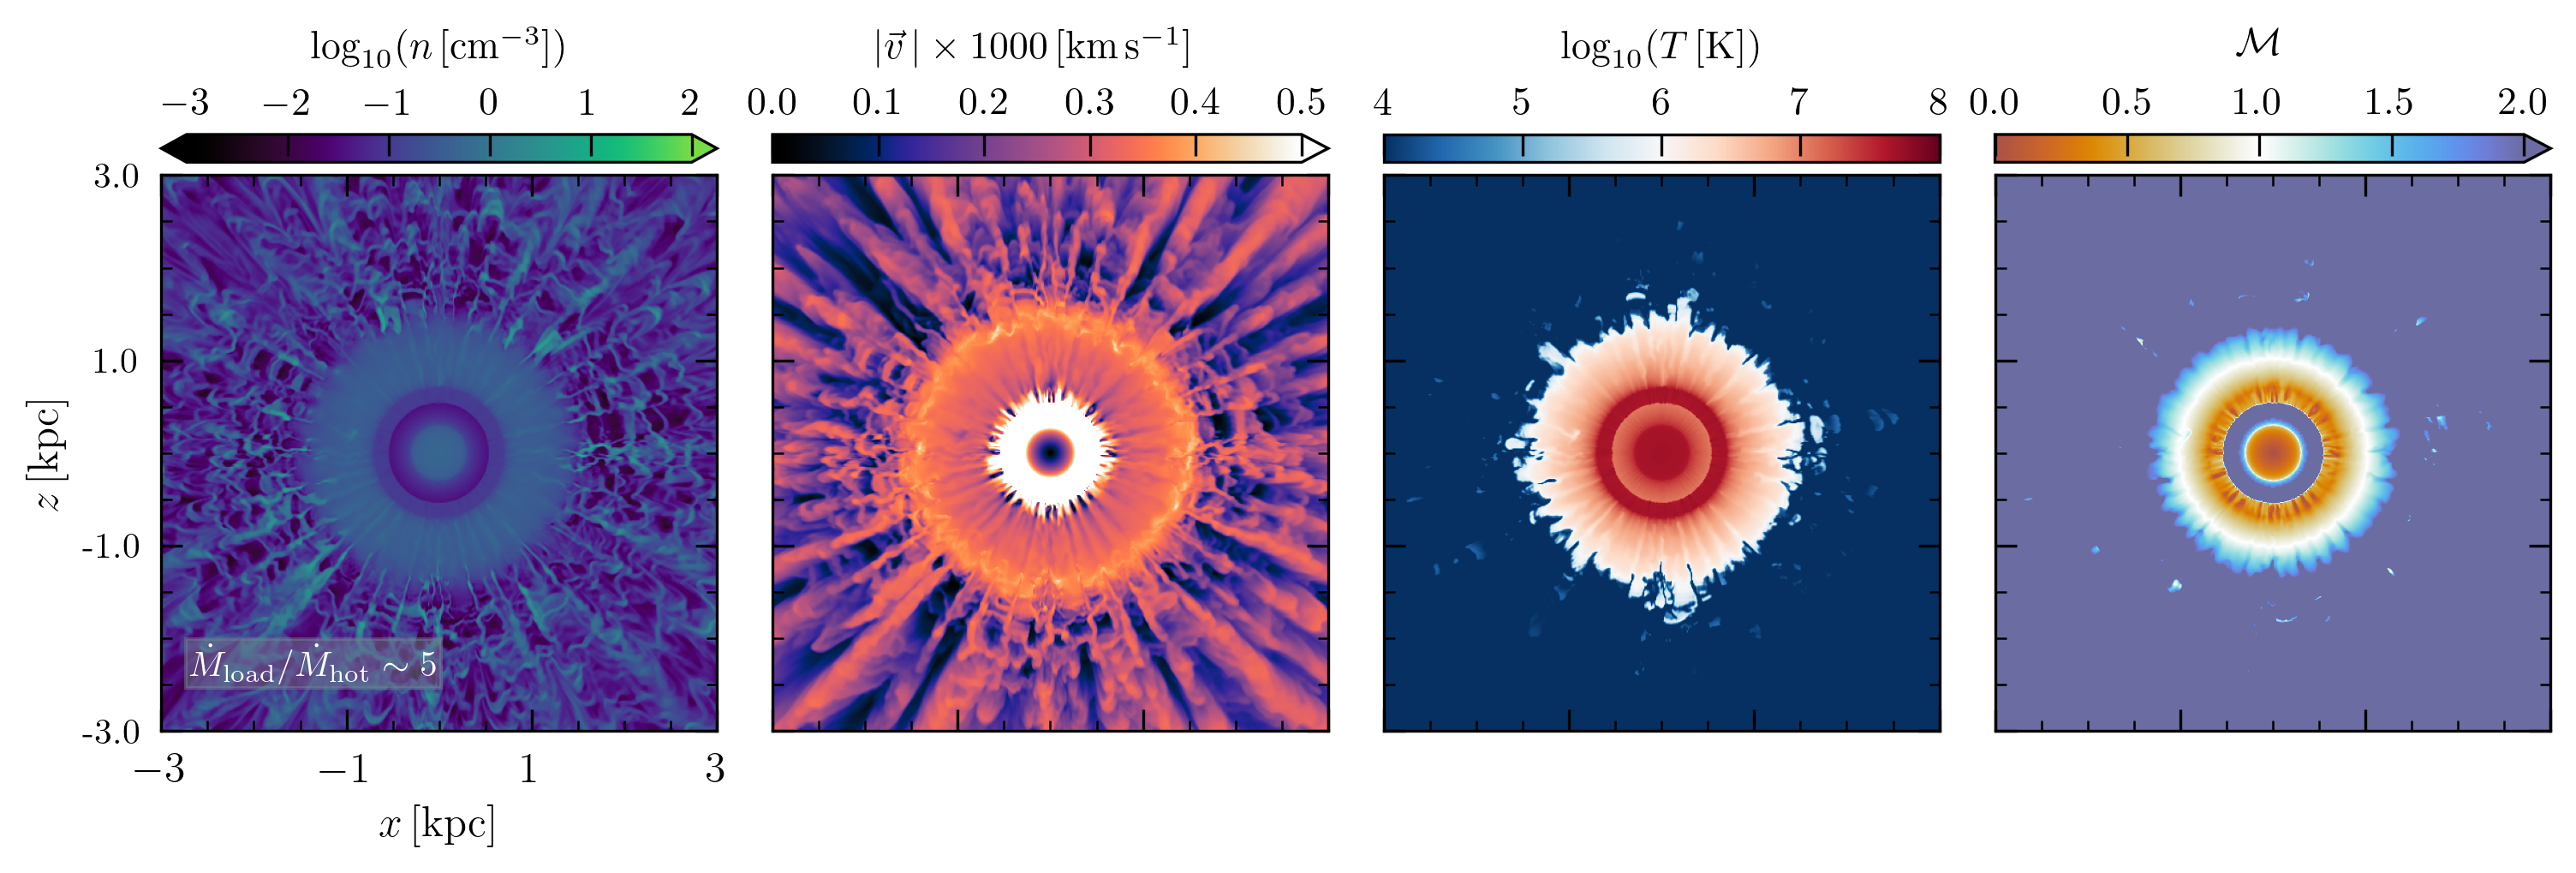

In [ ]:
dticks = 2.0      # kpc 
xticks = np.arange((-xlen/2),(xlen/2)+dticks,dticks)
yticks = np.arange((-zlen/2),(zlen/2)+dticks,dticks)
dt = 0.25    # Myr ; 100 kyr 


fig = plt.figure(dpi=300,figsize=(12,5))
ax1 = fig.add_subplot(1,4,1)
plt.setp(ax1.get_yticklabels(), visible=True)
plt.setp(ax1.get_xticklabels(), visible=True)

# May 28 2023, flipping temperature and velocity panels so easier to compare 
# ax2 (temperature, moved to position 143)
# ax3 (velocity, moved to positon 142)

ax2 = fig.add_subplot(1,4,3, sharey=ax1)
plt.setp(ax2.get_yticklabels(), visible=False)
plt.setp(ax2.get_xticklabels(), visible=False)


ax3 = fig.add_subplot(1,4,2, sharey=ax2)
plt.setp(ax3.get_yticklabels(), visible=False)
plt.setp(ax3.get_xticklabels(), visible=False)

ax4 = fig.add_subplot(1,4,4, sharex=ax1)
plt.setp(ax4.get_yticklabels(), visible=False)
plt.setp(ax4.get_xticklabels(), visible=False)



# Now to add fake color bars to the other 6 panels so the sizes are exactly the same


divider4 = make_axes_locatable(ax4)



cax4 = divider4.new_vertical(size="5%", pad=0.05)





#cax4.axis('off')
#cax5.axis('off')
#cax6.axis('off')
#cax7.axis('off')


nlog_min = -3 
nlog_max = 2 
nlog_ticks = [-3,-2,-1,0,1,2]
nlog_ticklabels = ['-3','-2','-1','0','1','2']
nlog_cmap = cmr.lavender 


Tlog_min = 4 
Tlog_max = 8 
Tlog_ticks = [4,5,6,7,8]
Tlog_ticklabels = ['4','5','6','7','8']
Tlog_cmap = "RdBu_r"


v_min = 0.0
v_max = 0.5 
v_ticks = [0,0.1,0.2,0.3,0.4,0.5]
v_ticklabels = ['0.0','0.1','0.2','0.3','0.4','0.5']
v_cmap = cmr.torch

M_min = 0.0
M_max = 2.0
M_ticks = [0.0,0.5,1.0,1.5,2.0]
M_ticklabels = ['0.0','0.5','1.0','1.5','2.0']
M_cmap = cmr.prinsenvlag

label_height = 3.0

divider = make_axes_locatable(ax1)
cax = divider.new_vertical(size='5%', pad=0.05)
fig.add_axes(cax)
#text = ax1.annotate('$\\texttt{A0}$ ($\dot{\mu}_0=15$)', xy=(0.05,0.875), color='white',size=10,xycoords=ax1.transAxes, bbox=dict(facecolor='slategray', edgecolor='slategray', alpha=0.5, pad=1.0))
text2 = ax1.annotate('$\dot{M}_\mathrm{load}/\dot{M}_\mathrm{hot} \sim 5$', xy=(0.05,0.1), color='white',size=10,xycoords=ax1.transAxes, bbox=dict(facecolor='slategray', edgecolor='slategray', alpha=0.5, pad=1.0))
im = ax1.imshow((np.log10(n_a[:,int(ny/2),:])).T,cmap=nlog_cmap,origin='lower',extent=[-xlen/2,xlen/2,-zlen/2,zlen/2])
cbar=fig.colorbar(im,cax=cax,orientation ='horizontal',ticks=nlog_ticks,shrink=0.5,extend="both")
cbar.ax.set_xticklabels(nlog_ticklabels,rotation=0,size=11) 
cbar.ax.set_title('$\log_{10}(n\,$[cm$^{-3}$])', rotation=0, y=label_height,fontsize=11)
im.set_clim(nlog_min,nlog_max)  
#ax1.set_ylabel('$y\,$[kpc]')
cax.xaxis.set_ticks_position("top")
ax1.set_xticks(xticks)
ax1.set_yticks(yticks)
ax1.set_ylabel('$z\,$[kpc]')
ax1.set_xlabel('$x\,$[kpc]')
ax1.set_yticklabels(yticks,fontsize=10)
ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(which="minor",axis="both", direction="in", top='on',bottom ='on', left='on',right='on',pad=6)
ax1.tick_params(which="major",axis="both", direction="in", top='on',bottom ='on', left='on',right='on',pad=6)

divider = make_axes_locatable(ax2)
cax = divider.new_vertical(size='5%', pad=0.05)
fig.add_axes(cax)
#text = ax2.annotate('$R_C =0.50\,\mathrm{kpc}$ \n $\ R_A = 0.10\,\mathrm{kpc}$', xy=(0.05,0.875), color='white',size=10,xycoords=ax2.transAxes, bbox=dict(facecolor='slategray', edgecolor='slategray', alpha=0.5, pad=1.0))
im = ax2.imshow((np.log10(T_a[:,int(ny/2),:])).T,cmap=Tlog_cmap,origin='lower',extent=[-xlen/2,xlen/2,-zlen/2,zlen/2])
cbar=fig.colorbar(im,cax=cax,orientation ='horizontal',ticks=Tlog_ticks)
cbar.ax.set_xticklabels(Tlog_ticklabels,rotation=0,size=11) 
#cbar.ax.get_yaxis().labelpad = 20
cbar.ax.set_title('$\log_{10}(T\,$[K])', rotation=0, y=label_height,fontsize=11)
im.set_clim(Tlog_min,Tlog_max)  
cax.xaxis.set_ticks_position("top")
ax2.set_xticks(xticks)
ax2.set_yticks(yticks)
ax2.xaxis.set_minor_locator(AutoMinorLocator())
ax2.yaxis.set_minor_locator(AutoMinorLocator())
ax2.tick_params(which="minor",axis="both", direction="in", top='on',bottom ='on', left='on',right='on',pad=6)
ax2.tick_params(which="major",axis="both", direction="in", top='on',bottom ='on', left='on',right='on',pad=6)


divider = make_axes_locatable(ax3)
cax = divider.new_vertical(size='5%', pad=0.05)
fig.add_axes(cax)
#text = ax3.annotate('$\\beta=0.9$', xy=(0.05,0.9), color='white',size=10,xycoords=ax3.transAxes, bbox=dict(facecolor='slategray', edgecolor='slategray', alpha=0.5, pad=1.0))
im = ax3.imshow((vmag_a[:,int(ny/2),:]/1e8).T,cmap=v_cmap,origin='lower',extent=[-xlen/2,xlen/2,-zlen/2,zlen/2])
cbar=fig.colorbar(im,cax=cax,orientation ='horizontal',ticks=v_ticks,extend="max")
cbar.ax.set_xticklabels(v_ticklabels,rotation=0,size=11) 
#cbar.ax.get_yaxis().labelpad = 20
cbar.ax.set_title('$|\\vec{v} \, |\\times 1000 \,$[$\mathrm{km\,s^{-1}}$]', rotation=0, y=label_height,fontsize=11)
im.set_clim(v_min,v_max)  
cax.xaxis.set_ticks_position("top")
ax3.set_xticks(xticks)
ax3.set_yticks(yticks)
ax3.xaxis.set_minor_locator(AutoMinorLocator())
ax3.yaxis.set_minor_locator(AutoMinorLocator())
ax3.tick_params(which="minor",axis="both", direction="in", top='on',bottom ='on', left='on',right='on',pad=6)
ax3.tick_params(which="major",axis="both", direction="in", top='on',bottom ='on', left='on',right='on',pad=6)


divider = make_axes_locatable(ax4)
cax = divider.new_vertical(size='5%', pad=0.05)
fig.add_axes(cax)
#text = ax4.annotate('$\\beta=0.9$', xy=(0.05,0.9), color='white',size=10,xycoords=ax4.transAxes, bbox=dict(facecolor='slategray', edgecolor='slategray', alpha=0.5, pad=1.0))
im = ax4.imshow((M_a[:,int(ny/2),:]).T,cmap=M_cmap,origin='lower',extent=[-xlen/2,xlen/2,-zlen/2,zlen/2])
cbar=fig.colorbar(im,cax=cax,orientation ='horizontal',ticks=M_ticks,extend="max")
cbar.ax.set_xticklabels(M_ticklabels,rotation=0,size=11) 
#cbar.ax.get_yaxis().labelpad = 20
cbar.ax.set_title('$\mathcal{M}$', rotation=0, y=label_height,fontsize=11)
im.set_clim(M_min,M_max)  
cax.xaxis.set_ticks_position("top")
ax4.set_xticks(xticks)
ax4.set_yticks(yticks)
ax4.xaxis.set_minor_locator(AutoMinorLocator())
ax4.yaxis.set_minor_locator(AutoMinorLocator())
ax4.tick_params(which="minor",axis="both", direction="in", top='on',bottom ='on', left='on',right='on',pad=6)
ax4.tick_params(which="major",axis="both", direction="in", top='on',bottom ='on', left='on',right='on',pad=6)


fig.subplots_adjust(hspace=0.0,wspace=0.1)
plt.savefig('mudot15_1x4_NEW.pdf',facecolor='white',bbox_inches='tight',pad_inches=0.05)

# Make 1D skewer plots for $\dot{\mu}_0=15$

In [3]:
xlen = 6.0
ylen = 6.0 
zlen = 6.0

x_cen = xlen / 2.0 * kpc 
y_cen = ylen / 2.0 * kpc 
z_cen = zlen / 2.0 * kpc 

nx = 512
ny = 512
nz = 512

x = np.linspace(0,xlen,nx) * kpc
y = np.linspace(0,ylen,ny) * kpc
z = np.linspace(0,zlen,nz) * kpc

# Generate the grid and then the shifted positions 
xm, ym, zm = np.meshgrid(x,y,z,indexing='ij')
xS, yS, zS = xm - x_cen, ym - y_cen, zm - z_cen

# Generate spherical coordinates on cartesian grid 
r_sph     = np.sqrt(xS**2 + yS**2 + zS**2 )
theta_sph = np.arctan2(np.sqrt(xS**2 + yS**2), zS)
phi_sph   = np.arctan2(yS, xS) 

number = 0
# Load in all of the data... this will kill the computer memory. 

datapath_a = '/Users/dustin/Desktop/cholla_simulations/2023/mass-loading/spherical_data/2022_512cubed_sims/'
datapath_b = datapath_a
datapath_c = datapath_a

# number of the h5 file
h5n_a = 80


for i in np.arange(0,number+1,1):
    # DATA [A] 
    DE = 1 
    SCALAR = 1 # file b for mudot 15 
    f_a = h5py.File(datapath_c+'mli_b_'+str(h5n_a)+'.h5', 'r')
    head_a = f_a.attrs
    nx = head_a['dims'][0]
    ny = head_a['dims'][1]
    nz = head_a['dims'][2]
    gamma = head_a['gamma'][0]
    dunit = head_a['density_unit']
    vunit = head_a['velocity_unit']
    punit = head_a['energy_unit']
    d_a  = np.array(f_a['density'])      # mass density
    mx_a = np.array(f_a['momentum_x'])   # x-momentum
    my_a = np.array(f_a['momentum_y'])   # y-momentum
    mz_a = np.array(f_a['momentum_z'])   # z-momentum
    E_a  = np.array(f_a['Energy'])       # total energy density
    vx_a = mx_a/d_a
    vy_a = my_a/d_a
    vz_a = mz_a/d_a
    if DE:
        e_a  = np.array(f_a['GasEnergy'])
        p_a  = e_a*(gamma-1.0)
        ge_a = e_a/d_a
    else:
        p_a  = (E_a - 0.5*d_a*(vx_a*vx_a + vy_a*vy_a + vz_a*vz_a)) * (gamma - 1.0)
        ge_a  = p_a/d_a/(gamma - 1.0)
    if SCALAR:
        s_a  = np.array(f_a['scalar0'])/d_a 
        
     # CGS units here    
    n_a     = d_a*dunit / (0.6 * mp)
    rho_a   = n_a * 0.6 * mp
    vx_a    = vx_a*vunit
    vy_a    = vy_a*vunit
    vz_a    = vz_a*vunit
    vmag_a  = np.sqrt(vx_a**2 + vy_a**2 + vz_a**2)
    p_a     = p_a*punit
    T_a     = p_a / (n_a*kb)
    cs_a = np.sqrt(gamma*(p_a)/(n_a*0.6*mp))
    M_a = vmag_a / cs_a 

/var/folders/hz/wjg31ld52r9cp4r029dnh6vm0000gn/T/ipykernel_17017/1581426961.py:101: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(xticks,fontsize=10)
/var/folders/hz/wjg31ld52r9cp4r029dnh6vm0000gn/T/ipykernel_17017/1581426961.py:107: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3.set_xticklabels(xticks,fontsize=10)


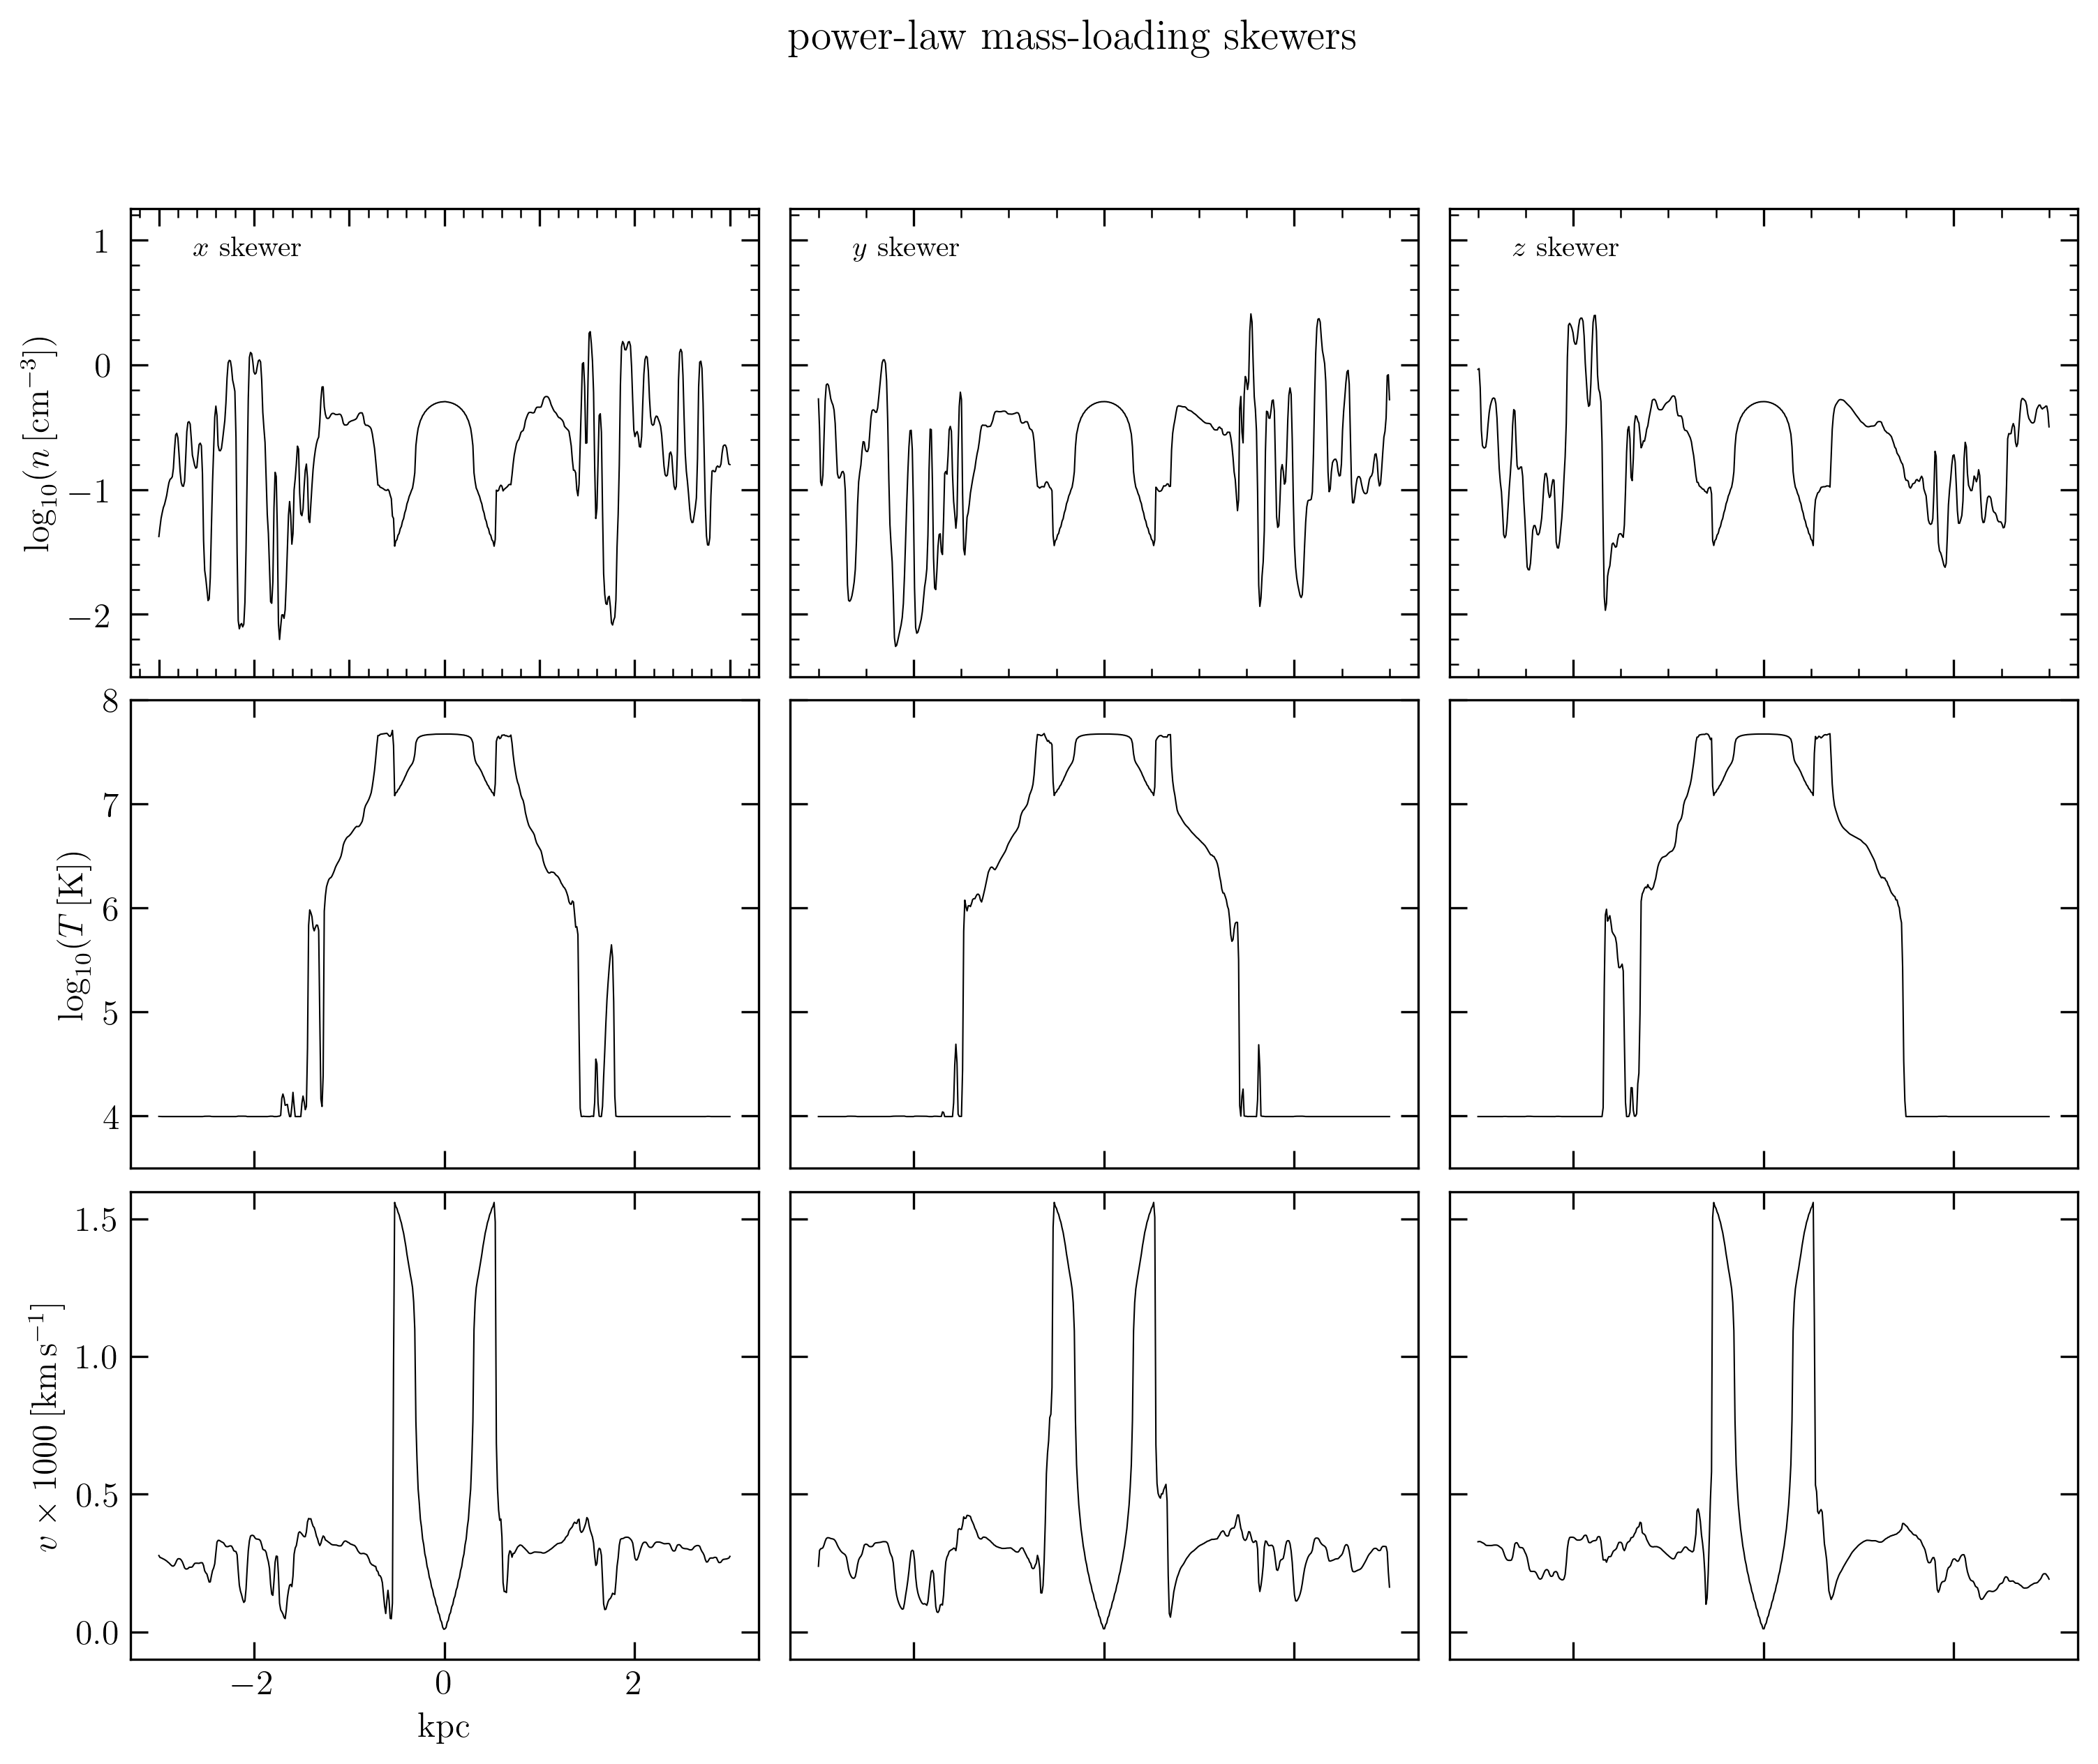

In [19]:
dticks = 1.0      # kpc 
xticks = np.arange((-xlen/2),(xlen/2)+dticks,dticks)

fig = plt.figure(dpi=300,figsize=(12,9))
ax1 = fig.add_subplot(3,3,1)
ax2 = fig.add_subplot(3,3,2)
ax3 = fig.add_subplot(3,3,3)

ax4 = fig.add_subplot(3,3,4)
ax5 = fig.add_subplot(3,3,5)
ax6 = fig.add_subplot(3,3,6)

ax7 = fig.add_subplot(3,3,7)
ax8 = fig.add_subplot(3,3,8)
ax9 = fig.add_subplot(3,3,9)

plt.setp(ax1.get_yticklabels(), visible=True)
plt.setp(ax1.get_xticklabels(), visible=False)

plt.setp(ax2.get_yticklabels(), visible=False)
plt.setp(ax2.get_xticklabels(), visible=False)

plt.setp(ax3.get_yticklabels(), visible=False)
plt.setp(ax3.get_xticklabels(), visible=False)

plt.setp(ax4.get_yticklabels(), visible=True)
plt.setp(ax4.get_xticklabels(), visible=False)

plt.setp(ax5.get_yticklabels(), visible=False)
plt.setp(ax5.get_xticklabels(), visible=False)

plt.setp(ax6.get_yticklabels(), visible=False)
plt.setp(ax6.get_xticklabels(), visible=False)

plt.setp(ax7.get_yticklabels(), visible=True)
plt.setp(ax7.get_xticklabels(), visible=True)

plt.setp(ax8.get_yticklabels(), visible=False)
plt.setp(ax8.get_xticklabels(), visible=False)

plt.setp(ax9.get_yticklabels(), visible=False)
plt.setp(ax9.get_xticklabels(), visible=False)

nlog_min = -2.5
nlog_max = 1.25

Tlog_min = 3.5
Tlog_max = 8.0 

v_min = -0.1 
v_max = 1.6

color = 'black'
lw = 0.5 



ax1.plot(x[:]/kpc-xlen/2.0,np.log10(n_a[:,int(ny/2),int(nz/2)]),c=color,lw=lw)
ax2.plot(y[:]/kpc-xlen/2.0,np.log10(n_a[int(nx/2),:,int(nz/2)]),c=color,lw=lw)
ax3.plot(z[:]/kpc-xlen/2.0,np.log10(n_a[int(nx/2),int(ny/2),:]),c=color,lw=lw)

ax4.plot(x[:]/kpc-xlen/2.0,np.log10(T_a[:,int(ny/2),int(nz/2)]),c=color,lw=lw)
ax5.plot(y[:]/kpc-xlen/2.0,np.log10(T_a[int(nx/2),:,int(nz/2)]),c=color,lw=lw)
ax6.plot(z[:]/kpc-xlen/2.0,np.log10(T_a[int(nx/2),int(ny/2),:]),c=color,lw=lw)

ax7.plot(x[:]/kpc-xlen/2.0,vmag_a[:,int(ny/2),int(nz/2)]/1e8,c=color,lw=lw)
ax8.plot(y[:]/kpc-xlen/2.0,vmag_a[int(nx/2),:,int(nz/2)]/1e8,c=color,lw=lw)
ax9.plot(z[:]/kpc-xlen/2.0,vmag_a[int(nx/2),int(ny/2),:]/1e8,c=color,lw=lw)


ax1.set_ylim(nlog_min,nlog_max)
ax2.set_ylim(nlog_min,nlog_max)
ax3.set_ylim(nlog_min,nlog_max)

ax4.set_ylim(Tlog_min,Tlog_max)
ax5.set_ylim(Tlog_min,Tlog_max)
ax6.set_ylim(Tlog_min,Tlog_max)

ax7.set_ylim(v_min,v_max)
ax8.set_ylim(v_min,v_max)
ax9.set_ylim(v_min,v_max)

text = ax1.annotate('$x$ skewer', xy=(0.1,0.9), color='black',size=10,xycoords=ax1.transAxes, bbox=dict(facecolor='white', edgecolor='white', alpha=0.5, pad=1.0))
text = ax2.annotate('$y$ skewer', xy=(0.1,0.9), color='black',size=10,xycoords=ax2.transAxes, bbox=dict(facecolor='white', edgecolor='white', alpha=0.5, pad=1.0))
text = ax3.annotate('$z$ skewer', xy=(0.1,0.9), color='black',size=10,xycoords=ax3.transAxes, bbox=dict(facecolor='white', edgecolor='white', alpha=0.5, pad=1.0))



ax7.set_xlabel("kpc")
ax1.set_ylabel("$\log_{10}(n\,\mathrm{[cm^{-3}]})$")
ax4.set_ylabel("$\log_{10}(T\,\mathrm{[K]})$")
ax7.set_ylabel("$v \\times 1000 \, \mathrm{[km\,s^{-1}]}$")
ax1.set_xticks(xticks)

ax1.set_xticklabels(xticks,fontsize=10)
ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(which="minor",axis="both", direction="in", top='on',bottom ='on', left='on',right='on',pad=6)
ax1.tick_params(which="major",axis="both", direction="in", top='on',bottom ='on', left='on',right='on',pad=6)

ax2.set_xticklabels(xticks,fontsize=10)
ax2.xaxis.set_minor_locator(AutoMinorLocator())
ax2.yaxis.set_minor_locator(AutoMinorLocator())
ax2.tick_params(which="minor",axis="both", direction="in", top='on',bottom ='on', left='on',right='on',pad=6)
ax2.tick_params(which="major",axis="both", direction="in", top='on',bottom ='on', left='on',right='on',pad=6)

ax3.set_xticklabels(xticks,fontsize=10)
ax3.xaxis.set_minor_locator(AutoMinorLocator())
ax3.yaxis.set_minor_locator(AutoMinorLocator())
ax3.tick_params(which="minor",axis="both", direction="in", top='on',bottom ='on', left='on',right='on',pad=6)
ax3.tick_params(which="major",axis="both", direction="in", top='on',bottom ='on', left='on',right='on',pad=6)


fig.suptitle("power-law mass-loading skewers")
fig.subplots_adjust(hspace=0.05,wspace=0.05)

plt.savefig('power-law_mudot_skewers.pdf',facecolor='white',bbox_inches='tight',pad_inches=0.05)

# Make 1x4 figure for MLI_b_truncated_and_uniform_HR

In [7]:
xlen = 6.0
ylen = 6.0 
zlen = 6.0

x_cen = xlen / 2.0 * kpc 
y_cen = ylen / 2.0 * kpc 
z_cen = zlen / 2.0 * kpc 

x = np.linspace(0,xlen,nx) * kpc
y = np.linspace(0,ylen,ny) * kpc
z = np.linspace(0,zlen,nz) * kpc

# Generate the grid and then the shifted positions 
xm, ym, zm = np.meshgrid(x,y,z,indexing='ij')
xS, yS, zS = xm - x_cen, ym - y_cen, zm - z_cen

# Generate spherical coordinates on cartesian grid 
r_sph     = np.sqrt(xS**2 + yS**2 + zS**2 )
theta_sph = np.arctan2(np.sqrt(xS**2 + yS**2), zS)
phi_sph   = np.arctan2(yS, xS) 

number = 0
# Load in all of the data... this will kill the computer memory. 

datapath_a = '/Users/dustin/Desktop/cholla_simulations/2023/mass-loading/spherical_data/mli_b_truncated_and_uniform_HR/'
datapath_b = datapath_a
datapath_c = datapath_a

# number of the h5 file
h5n_a = 4


for i in np.arange(0,number+1,1):
    # DATA [A] 
    DE = 1 
    SCALAR = 1 # file b for mudot 15 
    f_a = h5py.File(datapath_c+str(h5n_a)+'.h5', 'r')
    head_a = f_a.attrs
    nx = head_a['dims'][0]
    ny = head_a['dims'][1]
    nz = head_a['dims'][2]
    gamma = head_a['gamma'][0]
    dunit = head_a['density_unit']
    vunit = head_a['velocity_unit']
    punit = head_a['energy_unit']
    d_a  = np.array(f_a['density'])      # mass density
    mx_a = np.array(f_a['momentum_x'])   # x-momentum
    my_a = np.array(f_a['momentum_y'])   # y-momentum
    mz_a = np.array(f_a['momentum_z'])   # z-momentum
    E_a  = np.array(f_a['Energy'])       # total energy density
    vx_a = mx_a/d_a
    vy_a = my_a/d_a
    vz_a = mz_a/d_a
    if DE:
        e_a  = np.array(f_a['GasEnergy'])
        p_a  = e_a*(gamma-1.0)
        ge_a = e_a/d_a
    else:
        p_a  = (E_a - 0.5*d_a*(vx_a*vx_a + vy_a*vy_a + vz_a*vz_a)) * (gamma - 1.0)
        ge_a  = p_a/d_a/(gamma - 1.0)
    if SCALAR:
        s_a  = np.array(f_a['scalar0'])/d_a 
        
     # CGS units here    
    n_a     = d_a*dunit / (0.6 * mp)
    rho_a   = n_a * 0.6 * mp
    vx_a    = vx_a*vunit
    vy_a    = vy_a*vunit
    vz_a    = vz_a*vunit
    vmag_a  = np.sqrt(vx_a**2 + vy_a**2 + vz_a**2)
    p_a     = p_a*punit
    T_a     = p_a / (n_a*kb)
    cs_a = np.sqrt(gamma*(p_a)/(n_a*0.6*mp))
    M_a = vmag_a / cs_a 

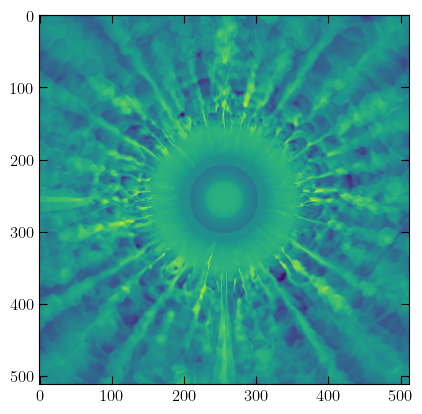

In [8]:
plt.imshow(np.log10(n_a[:,:,int(nz/2)]))

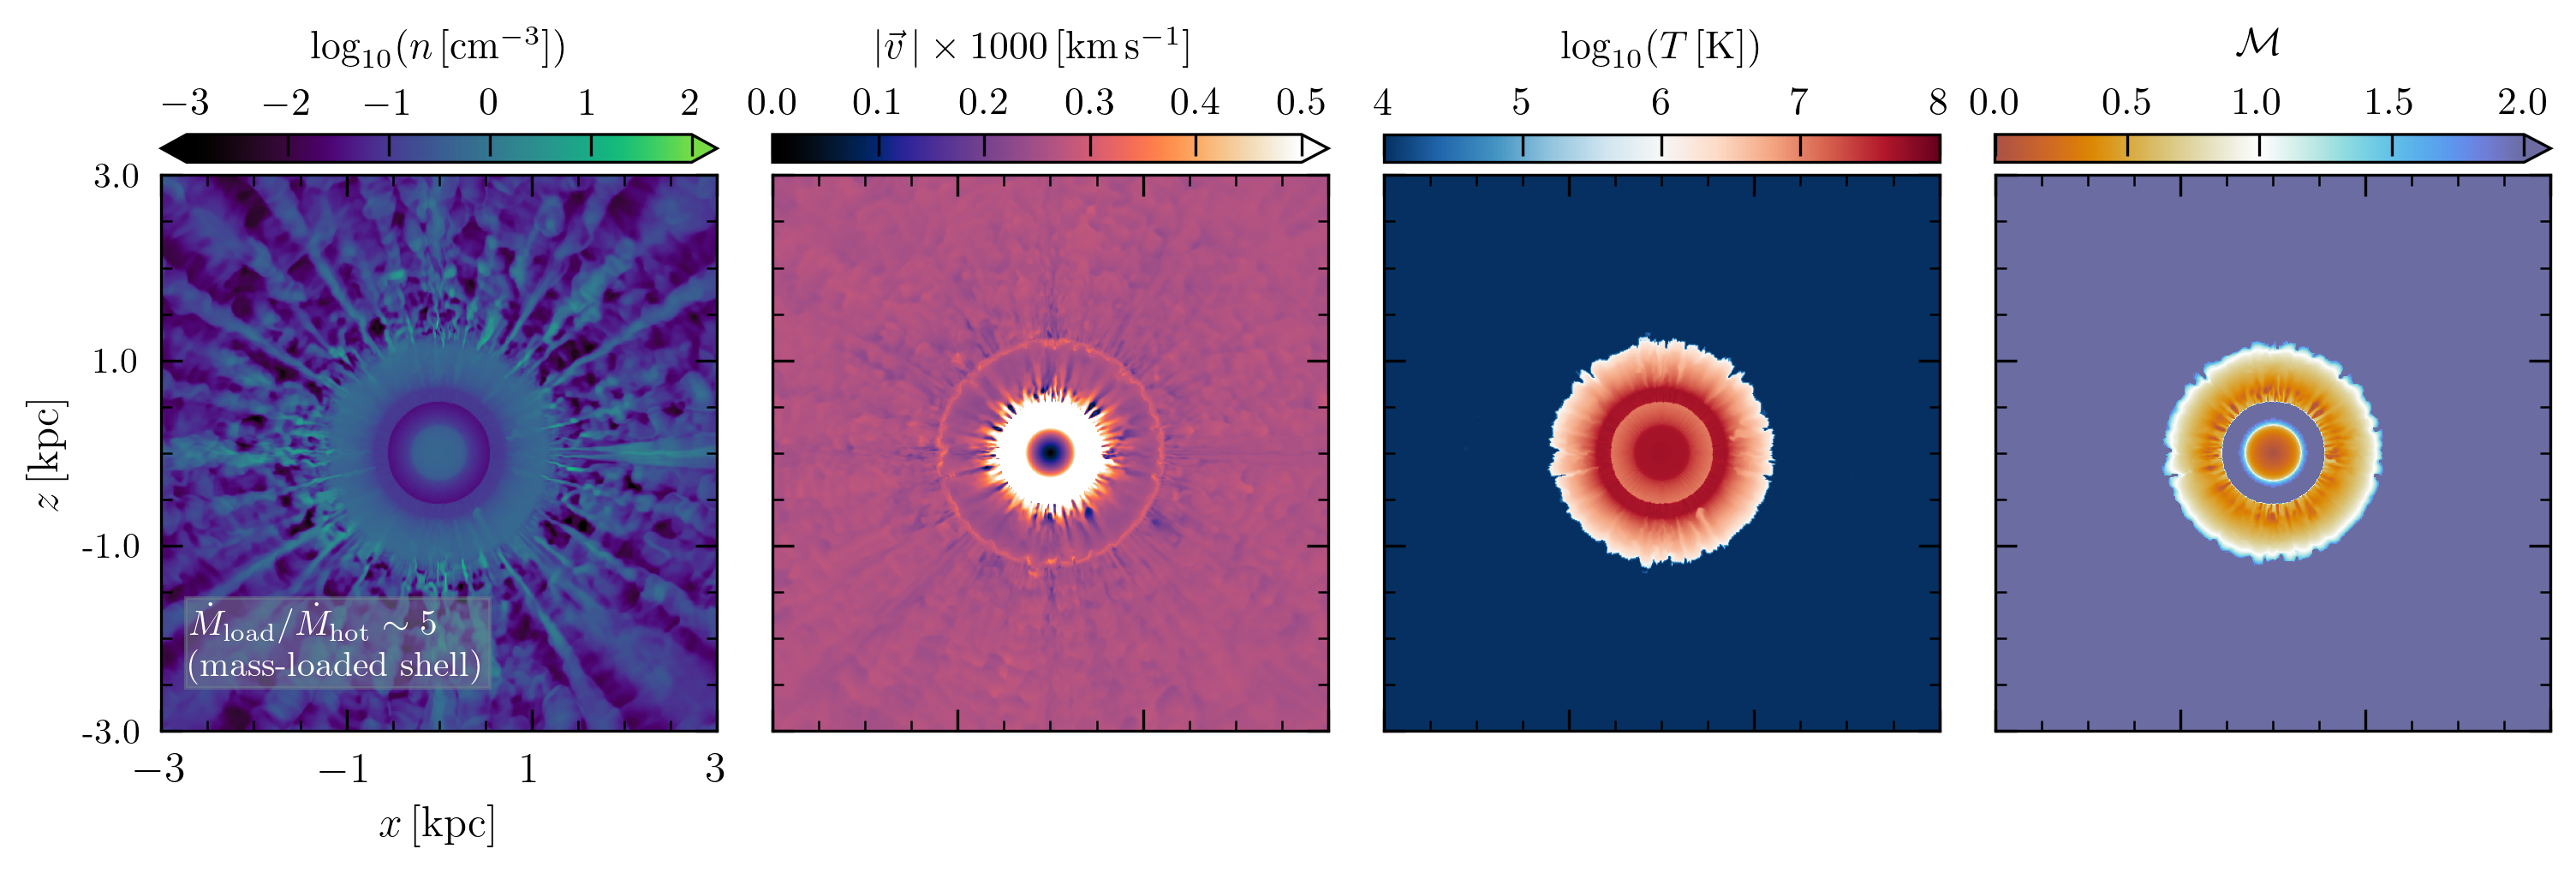

In [12]:
dticks = 2.0      # kpc 
xticks = np.arange((-xlen/2),(xlen/2)+dticks,dticks)
yticks = np.arange((-zlen/2),(zlen/2)+dticks,dticks)
dt = 0.25    # Myr ; 100 kyr 


fig = plt.figure(dpi=300,figsize=(12,5))
ax1 = fig.add_subplot(1,4,1)
plt.setp(ax1.get_yticklabels(), visible=True)
plt.setp(ax1.get_xticklabels(), visible=True)

# Swapped velocity and temperature panel positions, see above (143 , 142)

ax2 = fig.add_subplot(1,4,3, sharey=ax1)
plt.setp(ax2.get_yticklabels(), visible=False)
plt.setp(ax2.get_xticklabels(), visible=False)

ax3 = fig.add_subplot(1,4,2, sharey=ax2)
plt.setp(ax3.get_yticklabels(), visible=False)
plt.setp(ax3.get_xticklabels(), visible=False)

ax4 = fig.add_subplot(1,4,4, sharex=ax1)
plt.setp(ax4.get_yticklabels(), visible=False)
plt.setp(ax4.get_xticklabels(), visible=False)



# Now to add fake color bars to the other 6 panels so the sizes are exactly the same


divider4 = make_axes_locatable(ax4)



cax4 = divider4.new_vertical(size="5%", pad=0.05)





#cax4.axis('off')
#cax5.axis('off')
#cax6.axis('off')
#cax7.axis('off')


nlog_min = -3 
nlog_max = 2 
nlog_ticks = [-3,-2,-1,0,1,2]
nlog_ticklabels = ['-3','-2','-1','0','1','2']
nlog_cmap = cmr.lavender 


Tlog_min = 4 
Tlog_max = 8 
Tlog_ticks = [4,5,6,7,8]
Tlog_ticklabels = ['4','5','6','7','8']
Tlog_cmap = "RdBu_r"


v_min = 0.0
v_max = 0.5 
v_ticks = [0,0.1,0.2,0.3,0.4,0.5]
v_ticklabels = ['0.0','0.1','0.2','0.3','0.4','0.5']
v_cmap = cmr.torch

M_min = 0.0
M_max = 2.0
M_ticks = [0.0,0.5,1.0,1.5,2.0]
M_ticklabels = ['0.0','0.5','1.0','1.5','2.0']
M_cmap = cmr.prinsenvlag

label_height = 3.0

divider = make_axes_locatable(ax1)
cax = divider.new_vertical(size='5%', pad=0.05)
fig.add_axes(cax)
#text = ax1.annotate('$\\texttt{A0}$ ($\dot{\mu}_0=15$)', xy=(0.05,0.875), color='white',size=10,xycoords=ax1.transAxes, bbox=dict(facecolor='slategray', edgecolor='slategray', alpha=0.5, pad=1.0))
text2 = ax1.annotate('$\dot{M}_\mathrm{load}/\dot{M}_\mathrm{hot} \sim 5$ \n (mass-loaded shell)', xy=(0.05,0.1), color='white',size=10,xycoords=ax1.transAxes, bbox=dict(facecolor='slategray', edgecolor='slategray', alpha=0.5, pad=1.0))
im = ax1.imshow((np.log10(n_a[:,int(ny/2),:])).T,cmap=nlog_cmap,origin='lower',extent=[-xlen/2,xlen/2,-zlen/2,zlen/2])
cbar=fig.colorbar(im,cax=cax,orientation ='horizontal',ticks=nlog_ticks,shrink=0.5,extend="both")
cbar.ax.set_xticklabels(nlog_ticklabels,rotation=0,size=11) 
cbar.ax.set_title('$\log_{10}(n\,$[cm$^{-3}$])', rotation=0, y=label_height,fontsize=11)
im.set_clim(nlog_min,nlog_max)  
#ax1.set_ylabel('$y\,$[kpc]')
cax.xaxis.set_ticks_position("top")
ax1.set_xticks(xticks)
ax1.set_yticks(yticks)
ax1.set_ylabel('$z\,$[kpc]')
ax1.set_xlabel('$x\,$[kpc]')
ax1.set_yticklabels(yticks,fontsize=10)
ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(which="minor",axis="both", direction="in", top='on',bottom ='on', left='on',right='on',pad=6)
ax1.tick_params(which="major",axis="both", direction="in", top='on',bottom ='on', left='on',right='on',pad=6)

divider = make_axes_locatable(ax2)
cax = divider.new_vertical(size='5%', pad=0.05)
fig.add_axes(cax)
#text = ax2.annotate('$R_C =0.50\,\mathrm{kpc}$ \n $\ R_A = 0.10\,\mathrm{kpc}$', xy=(0.05,0.875), color='white',size=10,xycoords=ax2.transAxes, bbox=dict(facecolor='slategray', edgecolor='slategray', alpha=0.5, pad=1.0))
im = ax2.imshow((np.log10(T_a[:,int(ny/2),:])).T,cmap=Tlog_cmap,origin='lower',extent=[-xlen/2,xlen/2,-zlen/2,zlen/2])
cbar=fig.colorbar(im,cax=cax,orientation ='horizontal',ticks=Tlog_ticks)
cbar.ax.set_xticklabels(Tlog_ticklabels,rotation=0,size=11) 
#cbar.ax.get_yaxis().labelpad = 20
cbar.ax.set_title('$\log_{10}(T\,$[K])', rotation=0, y=label_height,fontsize=11)
im.set_clim(Tlog_min,Tlog_max)  
cax.xaxis.set_ticks_position("top")
ax2.set_xticks(xticks)
ax2.set_yticks(yticks)
ax2.xaxis.set_minor_locator(AutoMinorLocator())
ax2.yaxis.set_minor_locator(AutoMinorLocator())
ax2.tick_params(which="minor",axis="both", direction="in", top='on',bottom ='on', left='on',right='on',pad=6)
ax2.tick_params(which="major",axis="both", direction="in", top='on',bottom ='on', left='on',right='on',pad=6)


divider = make_axes_locatable(ax3)
cax = divider.new_vertical(size='5%', pad=0.05)
fig.add_axes(cax)
#text = ax3.annotate('$\\beta=0.9$', xy=(0.05,0.9), color='white',size=10,xycoords=ax3.transAxes, bbox=dict(facecolor='slategray', edgecolor='slategray', alpha=0.5, pad=1.0))
im = ax3.imshow((vmag_a[:,int(ny/2),:]/1e8).T,cmap=v_cmap,origin='lower',extent=[-xlen/2,xlen/2,-zlen/2,zlen/2])
cbar=fig.colorbar(im,cax=cax,orientation ='horizontal',ticks=v_ticks,extend="max")
cbar.ax.set_xticklabels(v_ticklabels,rotation=0,size=11) 
#cbar.ax.get_yaxis().labelpad = 20
cbar.ax.set_title('$|\\vec{v} \, |\\times 1000 \,$[$\mathrm{km\,s^{-1}}$]', rotation=0, y=label_height,fontsize=11)
im.set_clim(v_min,v_max)  
cax.xaxis.set_ticks_position("top")
ax3.set_xticks(xticks)
ax3.set_yticks(yticks)
ax3.xaxis.set_minor_locator(AutoMinorLocator())
ax3.yaxis.set_minor_locator(AutoMinorLocator())
ax3.tick_params(which="minor",axis="both", direction="in", top='on',bottom ='on', left='on',right='on',pad=6)
ax3.tick_params(which="major",axis="both", direction="in", top='on',bottom ='on', left='on',right='on',pad=6)


divider = make_axes_locatable(ax4)
cax = divider.new_vertical(size='5%', pad=0.05)
fig.add_axes(cax)
#text = ax4.annotate('$\\beta=0.9$', xy=(0.05,0.9), color='white',size=10,xycoords=ax4.transAxes, bbox=dict(facecolor='slategray', edgecolor='slategray', alpha=0.5, pad=1.0))
im = ax4.imshow((M_a[:,int(ny/2),:]).T,cmap=M_cmap,origin='lower',extent=[-xlen/2,xlen/2,-zlen/2,zlen/2])
cbar=fig.colorbar(im,cax=cax,orientation ='horizontal',ticks=M_ticks,extend="max")
cbar.ax.set_xticklabels(M_ticklabels,rotation=0,size=11) 
#cbar.ax.get_yaxis().labelpad = 20
cbar.ax.set_title('$\mathcal{M}$', rotation=0, y=label_height,fontsize=11)
im.set_clim(M_min,M_max)  
cax.xaxis.set_ticks_position("top")
ax4.set_xticks(xticks)
ax4.set_yticks(yticks)
ax4.xaxis.set_minor_locator(AutoMinorLocator())
ax4.yaxis.set_minor_locator(AutoMinorLocator())
ax4.tick_params(which="minor",axis="both", direction="in", top='on',bottom ='on', left='on',right='on',pad=6)
ax4.tick_params(which="major",axis="both", direction="in", top='on',bottom ='on', left='on',right='on',pad=6)


fig.subplots_adjust(hspace=0.0,wspace=0.1)
plt.savefig('mudot_uni_1x4_NEW.pdf',facecolor='white',bbox_inches='tight',pad_inches=0.05)

/var/folders/hz/wjg31ld52r9cp4r029dnh6vm0000gn/T/ipykernel_17017/2223914219.py:101: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(xticks,fontsize=10)
/var/folders/hz/wjg31ld52r9cp4r029dnh6vm0000gn/T/ipykernel_17017/2223914219.py:107: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3.set_xticklabels(xticks,fontsize=10)


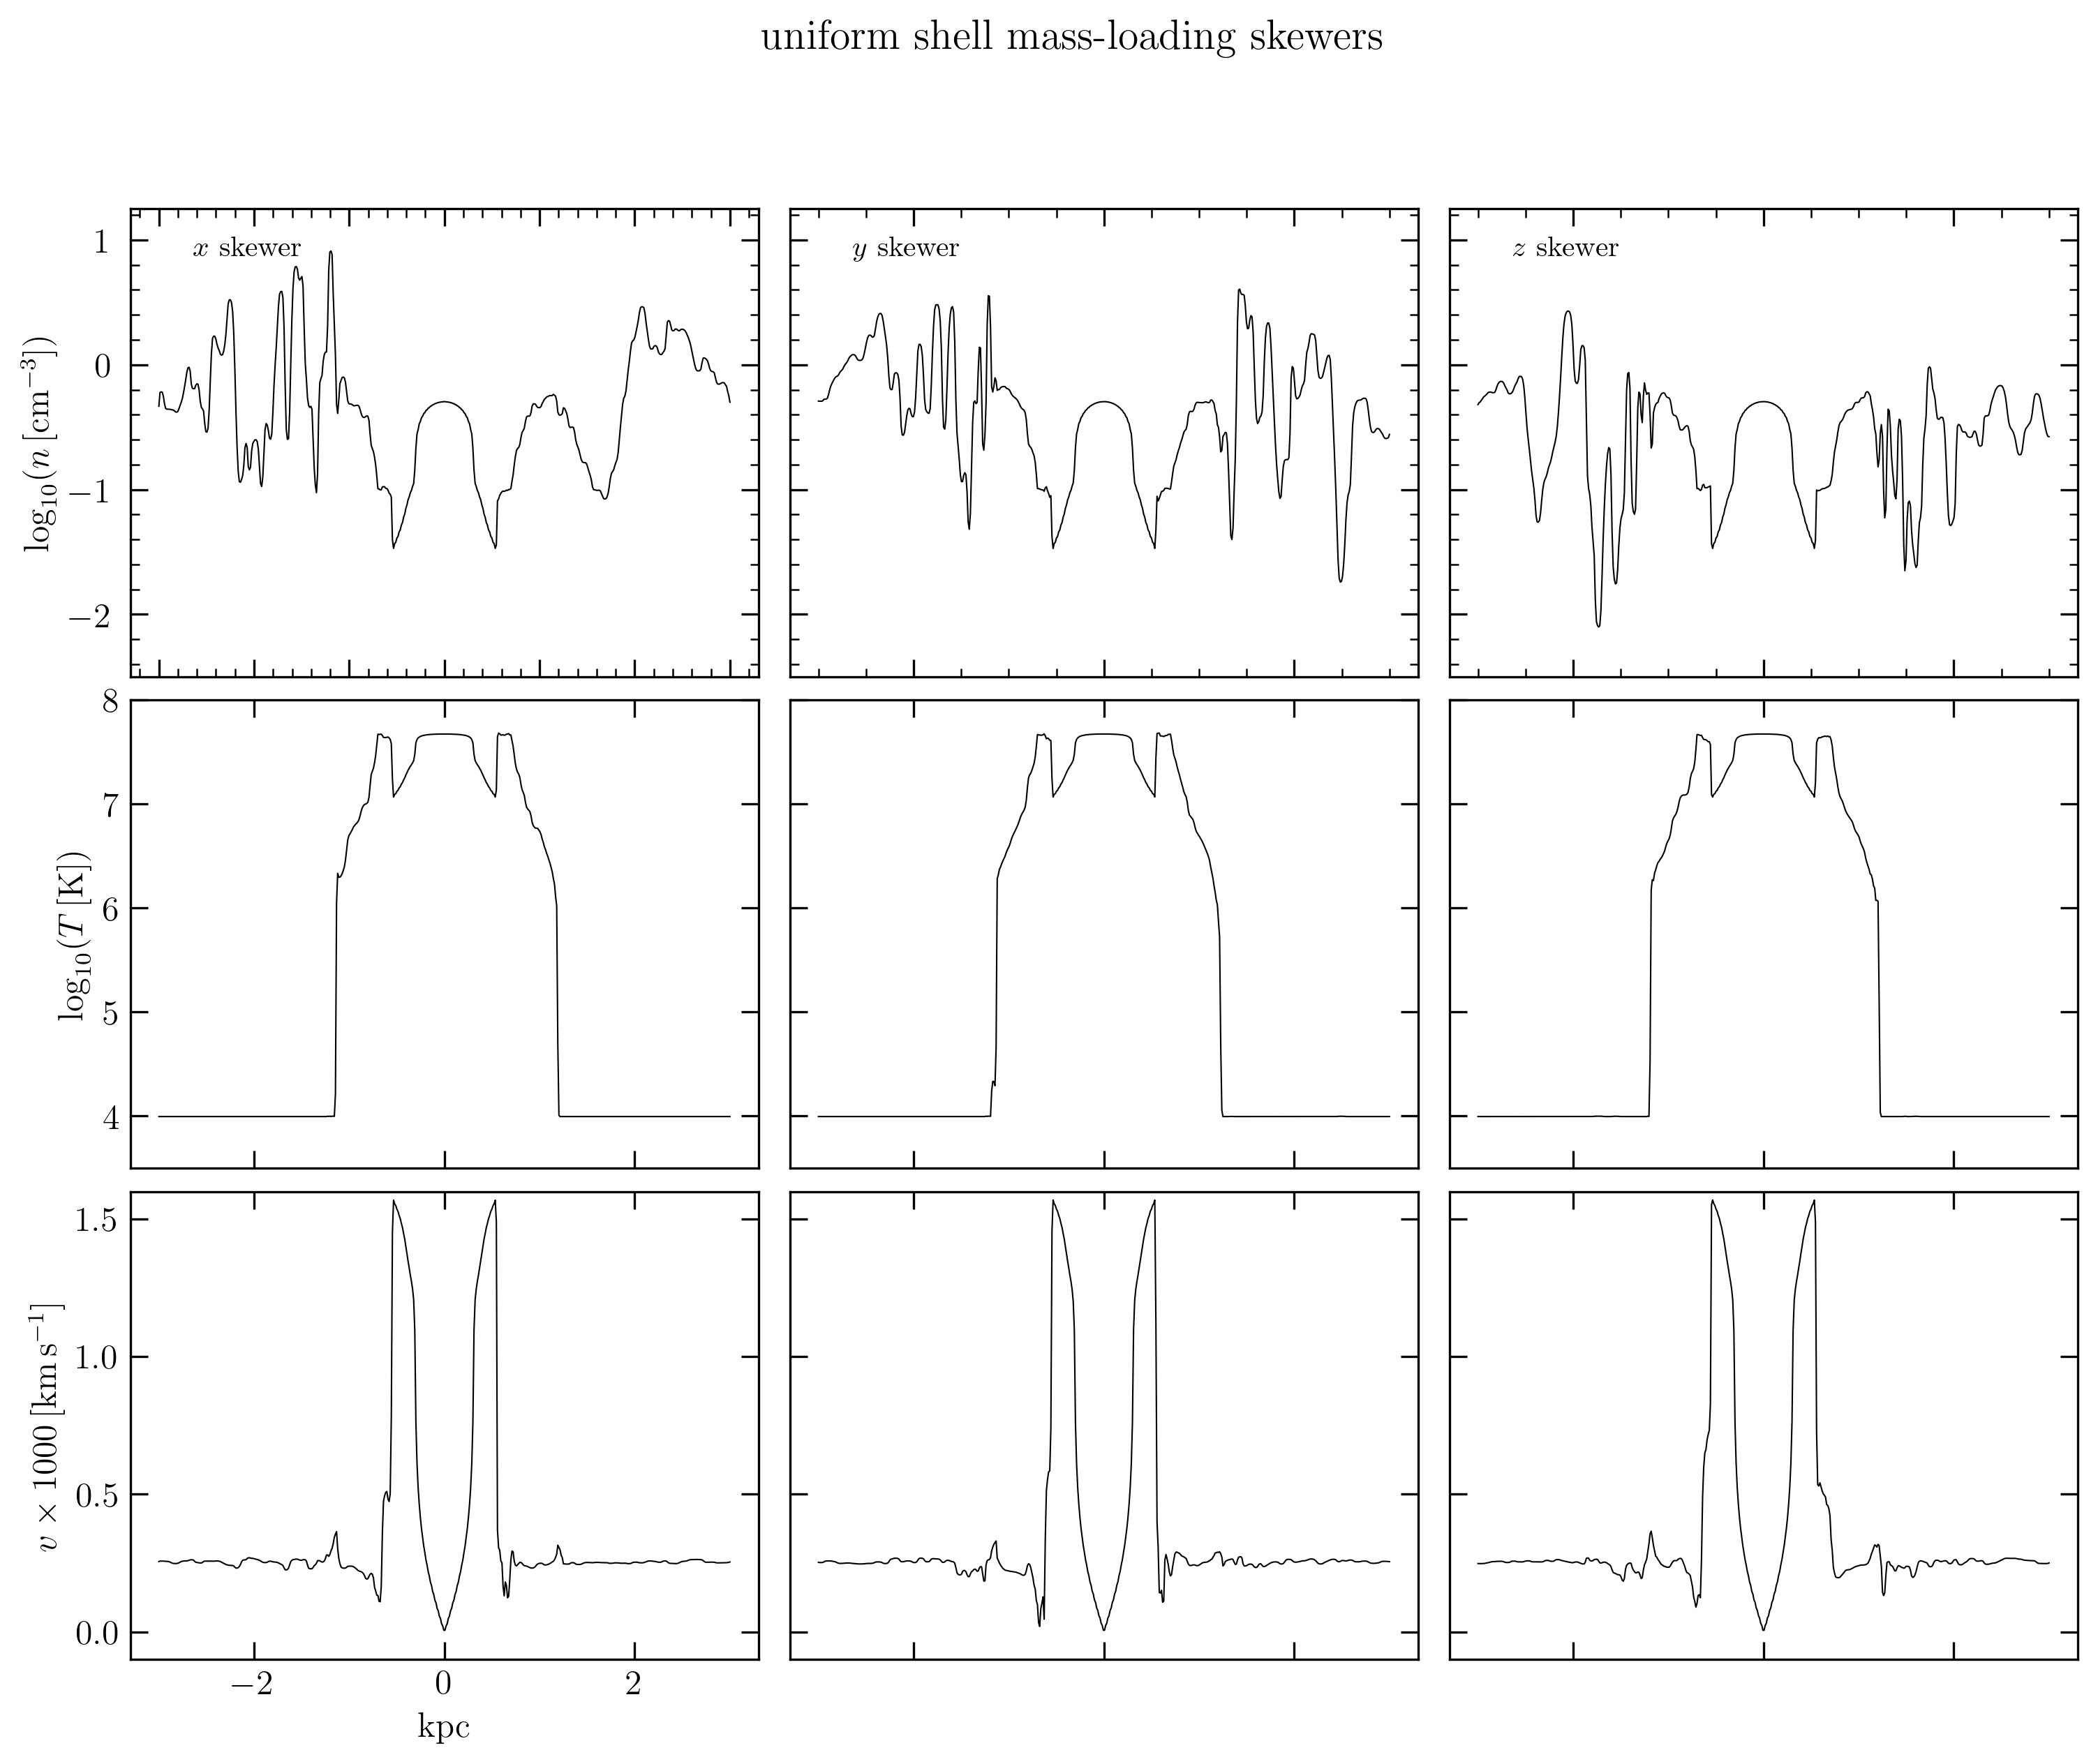

In [23]:
dticks = 1.0      # kpc 
xticks = np.arange((-xlen/2),(xlen/2)+dticks,dticks)

fig = plt.figure(dpi=300,figsize=(12,9))
ax1 = fig.add_subplot(3,3,1)
ax2 = fig.add_subplot(3,3,2)
ax3 = fig.add_subplot(3,3,3)

ax4 = fig.add_subplot(3,3,4)
ax5 = fig.add_subplot(3,3,5)
ax6 = fig.add_subplot(3,3,6)

ax7 = fig.add_subplot(3,3,7)
ax8 = fig.add_subplot(3,3,8)
ax9 = fig.add_subplot(3,3,9)

plt.setp(ax1.get_yticklabels(), visible=True)
plt.setp(ax1.get_xticklabels(), visible=False)

plt.setp(ax2.get_yticklabels(), visible=False)
plt.setp(ax2.get_xticklabels(), visible=False)

plt.setp(ax3.get_yticklabels(), visible=False)
plt.setp(ax3.get_xticklabels(), visible=False)

plt.setp(ax4.get_yticklabels(), visible=True)
plt.setp(ax4.get_xticklabels(), visible=False)

plt.setp(ax5.get_yticklabels(), visible=False)
plt.setp(ax5.get_xticklabels(), visible=False)

plt.setp(ax6.get_yticklabels(), visible=False)
plt.setp(ax6.get_xticklabels(), visible=False)

plt.setp(ax7.get_yticklabels(), visible=True)
plt.setp(ax7.get_xticklabels(), visible=True)

plt.setp(ax8.get_yticklabels(), visible=False)
plt.setp(ax8.get_xticklabels(), visible=False)

plt.setp(ax9.get_yticklabels(), visible=False)
plt.setp(ax9.get_xticklabels(), visible=False)

nlog_min = -2.5
nlog_max = 1.25

Tlog_min = 3.5
Tlog_max = 8.0 

v_min = -0.1 
v_max = 1.6

color = 'black'
lw = 0.5 



ax1.plot(x[:]/kpc-xlen/2.0,np.log10(n_a[:,int(ny/2),int(nz/2)]),c=color,lw=lw)
ax2.plot(y[:]/kpc-xlen/2.0,np.log10(n_a[int(nx/2),:,int(nz/2)]),c=color,lw=lw)
ax3.plot(z[:]/kpc-xlen/2.0,np.log10(n_a[int(nx/2),int(ny/2),:]),c=color,lw=lw)

ax4.plot(x[:]/kpc-xlen/2.0,np.log10(T_a[:,int(ny/2),int(nz/2)]),c=color,lw=lw)
ax5.plot(y[:]/kpc-xlen/2.0,np.log10(T_a[int(nx/2),:,int(nz/2)]),c=color,lw=lw)
ax6.plot(z[:]/kpc-xlen/2.0,np.log10(T_a[int(nx/2),int(ny/2),:]),c=color,lw=lw)

ax7.plot(x[:]/kpc-xlen/2.0,vmag_a[:,int(ny/2),int(nz/2)]/1e8,c=color,lw=lw)
ax8.plot(y[:]/kpc-xlen/2.0,vmag_a[int(nx/2),:,int(nz/2)]/1e8,c=color,lw=lw)
ax9.plot(z[:]/kpc-xlen/2.0,vmag_a[int(nx/2),int(ny/2),:]/1e8,c=color,lw=lw)


ax1.set_ylim(nlog_min,nlog_max)
ax2.set_ylim(nlog_min,nlog_max)
ax3.set_ylim(nlog_min,nlog_max)

ax4.set_ylim(Tlog_min,Tlog_max)
ax5.set_ylim(Tlog_min,Tlog_max)
ax6.set_ylim(Tlog_min,Tlog_max)

ax7.set_ylim(v_min,v_max)
ax8.set_ylim(v_min,v_max)
ax9.set_ylim(v_min,v_max)

text = ax1.annotate('$x$ skewer', xy=(0.1,0.9), color='black',size=10,xycoords=ax1.transAxes, bbox=dict(facecolor='white', edgecolor='white', alpha=0.5, pad=1.0))
text = ax2.annotate('$y$ skewer', xy=(0.1,0.9), color='black',size=10,xycoords=ax2.transAxes, bbox=dict(facecolor='white', edgecolor='white', alpha=0.5, pad=1.0))
text = ax3.annotate('$z$ skewer', xy=(0.1,0.9), color='black',size=10,xycoords=ax3.transAxes, bbox=dict(facecolor='white', edgecolor='white', alpha=0.5, pad=1.0))



ax7.set_xlabel("kpc")
ax1.set_ylabel("$\log_{10}(n\,\mathrm{[cm^{-3}]})$")
ax4.set_ylabel("$\log_{10}(T\,\mathrm{[K]})$")
ax7.set_ylabel("$v \\times 1000 \, \mathrm{[km\,s^{-1}]}$")
ax1.set_xticks(xticks)

ax1.set_xticklabels(xticks,fontsize=10)
ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(which="minor",axis="both", direction="in", top='on',bottom ='on', left='on',right='on',pad=6)
ax1.tick_params(which="major",axis="both", direction="in", top='on',bottom ='on', left='on',right='on',pad=6)

ax2.set_xticklabels(xticks,fontsize=10)
ax2.xaxis.set_minor_locator(AutoMinorLocator())
ax2.yaxis.set_minor_locator(AutoMinorLocator())
ax2.tick_params(which="minor",axis="both", direction="in", top='on',bottom ='on', left='on',right='on',pad=6)
ax2.tick_params(which="major",axis="both", direction="in", top='on',bottom ='on', left='on',right='on',pad=6)

ax3.set_xticklabels(xticks,fontsize=10)
ax3.xaxis.set_minor_locator(AutoMinorLocator())
ax3.yaxis.set_minor_locator(AutoMinorLocator())
ax3.tick_params(which="minor",axis="both", direction="in", top='on',bottom ='on', left='on',right='on',pad=6)
ax3.tick_params(which="major",axis="both", direction="in", top='on',bottom ='on', left='on',right='on',pad=6)


fig.suptitle("uniform shell mass-loading skewers")
fig.subplots_adjust(hspace=0.05,wspace=0.05)

plt.savefig('uniformshell_mudot_skewers.pdf',facecolor='white',bbox_inches='tight',pad_inches=0.05)